In [1491]:
import pandas as pd
import json
import os
import pylab as pl
import geopandas as gp
import glob
import zipfile
import numpy as np
from sklearn.cluster import KMeans
from matplotlib import cm
from descartes import PolygonPatch
import scipy.cluster as scp
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster as scp
import pandas as pd
from pandas.io.common import ZipFile
import pylab as plt
import seaborn

## (1) Find the number of businesses in 2010 and 2000.

### Download the file include the information of number of businesses in 2010 and 2000.

In [1]:
!wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp00totals.zip

--2016-12-17 09:26:59--  ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp00totals.zip
           => “zbp00totals.zip”
Resolving ftp.census.gov... 148.129.75.35, 2610:20:2010:a09:1000:0:9481:4b23
Connecting to ftp.census.gov|148.129.75.35|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /Econ2001_And_Earlier/CBP_CSV ... done.
==> SIZE zbp00totals.zip ... 628434
==> PASV ... done.    ==> RETR zbp00totals.zip ... done.
Length: 628434 (614K) (unauthoritative)

100%[======================================>] 628,434     --.-K/s   in 1.1s    

2016-12-17 09:27:00 (568 KB/s) - “zbp00totals.zip” saved [628434]



In [4]:
!wget ftp://ftp.census.gov/econ2010/CBP_CSV/zbp10totals.zip

--2016-12-17 09:28:19--  ftp://ftp.census.gov/econ2010/CBP_CSV/zbp10totals.zip
           => “zbp10totals.zip”
Resolving ftp.census.gov... 148.129.75.35, 2610:20:2010:a09:1000:0:9481:4b23
Connecting to ftp.census.gov|148.129.75.35|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /econ2010/CBP_CSV ... done.
==> SIZE zbp10totals.zip ... 797534
==> PASV ... done.    ==> RETR zbp10totals.zip ... done.
Length: 797534 (779K) (unauthoritative)

100%[======================================>] 797,534      507K/s   in 1.5s    

2016-12-17 09:28:21 (507 KB/s) - “zbp10totals.zip” saved [797534]



In [50]:
ls = []
for files in glob.glob(os.getenv("PUIDATA") + "/Final/*.zip"):
    zf = zipfile.ZipFile(files)
    df = pd.read_csv(zf.open(files[-15:].replace('.zip','.txt')))
    if any(df.columns == 'est'):
        df = df[['zip', 'est']]
    elif any(df.columns == 'EST'):
        df = df[['ZIP', 'EST']]
        df.rename(columns={'ZIP': 'zip', 'EST': 'est'}, inplace=True)
    else:
        print 'wrong column name'
    df.rename(columns={'est': files[-12:-10]}, inplace=True)
    ls.append(df)

In [2276]:
zp2000 = ls[1]

### Generate a dataframe of the number of businesses in 2000

In [2277]:
zp2000.head()

,zip,00
0,501,1
1,1001,493
2,1002,563
3,1003,13
4,1004,48


In [2278]:
zp2000.columns

Index([u'zip', u'00'], dtype='object')

In [2279]:
zp2010 = ls[0]

### Generate a dataframe of the number of businesses in 2010

In [54]:
zp2010.head()

,zip,10
0,501,2
1,1001,448
2,1002,570
3,1003,16
4,1004,21


In [136]:
zpb = pd.merge(zp2010, zp2000, on = 'zip', how = 'inner')

### Merge the data of two years

In [2282]:
zpb.head()

,zip,10,00
0,501,2,1
1,1001,448,493
2,1002,570,563
3,1003,16,13
4,1004,21,48


In [2283]:
zpb['zip'] = zpb['zip'].astype(unicode)

In [1338]:
zip_nyc_path = os.getenv("PUIDATA") + "/nyc-zip-code-tabulation-areas-polygons.geojson"
zip_nyc = gp.read_file(zip_nyc_path)

In [1339]:
zip_nyc.rename(columns = {"postalCode" : 'zip'},inplace = True)

In [1340]:
df_nyc = zpb.loc[zpb['zip'].isin(np.int64(zip_nyc['zip']))]

In [1341]:
df_nyc.head()

,zip,10,00
2884,10001,7241,7317
2885,10002,2872,2277
2886,10003,4113,3683
2887,10004,1398,1294
2888,10005,1266,1287


In [1345]:
df_nyc.set_index('zip', inplace=False)
df_nyc.isnull().sum(axis=1)[df_nyc.isnull().sum(axis=1) > 0]
df_nyc = df_nyc.drop(df_nyc.isnull().sum(axis=1)[df_nyc.isnull().sum(axis=1) > 5].index)
df_nyc.fillna(0, inplace=True)

In [1346]:
type(df_nyc)

pandas.core.frame.DataFrame

In [1344]:
df_nyc['zip'] = df_nyc['zip'].astype(float)

## 2) Gather a zipcode shapefile and merge the number of businesses with the zipcode shapfile

In [1347]:
zip_nyc.head()

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,zip
0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,1,Jackson Heights,NY,36,2.016328e+07,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,2,Glen Oaks,NY,36,2.260653e+07,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,3,New Hyde Park,NY,36,6.269333e+06,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,http://nyc.pediacities.com/Resource/PostalCode...,0,081,4,Bellerose,NY,36,4.941836e+07,35932.810639,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,http://nyc.pediacities.com/Resource/PostalCode...,0,081,5,Fresh Meadows,NY,36,6.938587e+07,38693.565676,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365


In [1348]:
nyzip = zip_nyc[['geometry','zip']]
nyzip.head()

,geometry,zip
0,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,POLYGON ((-73.81088634744755 40.72717187575918...,11365


In [171]:
nyziparea = zip_nyc.geometry.area

In [172]:
nyziparea.head()

0    0.000200
1    0.000224
2    0.000062
3    0.000489
4    0.000688
dtype: float64

In [173]:
nyzip['area'] = nyziparea

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [1349]:
nyzip.head()

,geometry,zip
0,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,POLYGON ((-73.81088634744755 40.72717187575918...,11365


In [2281]:
type(nyzip['zip'][0])

unicode

### Gather a zipcode shapefile and merge the number of businesses with the zipcode shapfile

In [2284]:
data_and_zip = pd.merge(nyzip, zpb, on = 'zip', how = 'inner')
data_and_zip.head()

,geometry,zip,area,10,00
0,POLYGON ((-73.86942457284175 40.74915687096787...,11372,0.000200,1629,1409
1,POLYGON ((-73.71068374074007 40.75004039450917...,11004,0.000224,229,189
2,POLYGON ((-73.70098278625547 40.73889569923034...,11040,0.000062,1494,1350
3,POLYGON ((-73.72270447144122 40.75373371438336...,11426,0.000489,248,213
4,POLYGON ((-73.81088634744755 40.72717187575918...,11365,0.000688,643,553


In [2297]:
density00 = np.log10(data_and_zip['00']/data_and_zip['area'])
density10 = np.log10(data_and_zip['10']/data_and_zip['area'])

## (3) Find the density of businesses and plot.

### Find the density of businesses and merge the data

In [2298]:
data_and_zip['density00'] = density00
data_and_zip['density10'] = density10

In [2299]:
data_and_zip.head()

,geometry,zip,area,10,00,density00,density10
0,POLYGON ((-73.86942457284175 40.74915687096787...,11372,0.000200,1629,1409,6.847934,6.910944
1,POLYGON ((-73.71068374074007 40.75004039450917...,11004,0.000224,229,189,5.925984,6.009358
2,POLYGON ((-73.70098278625547 40.73889569923034...,11040,0.000062,1494,1350,7.337704,7.381721
3,POLYGON ((-73.72270447144122 40.75373371438336...,11426,0.000489,248,213,5.638918,5.704990
4,POLYGON ((-73.81088634744755 40.72717187575918...,11365,0.000688,643,553,5.905344,5.970830


In [965]:
type(data_and_zip)

geopandas.geodataframe.GeoDataFrame

In [1377]:
type(data00_geo)

geopandas.geodataframe.GeoDataFrame

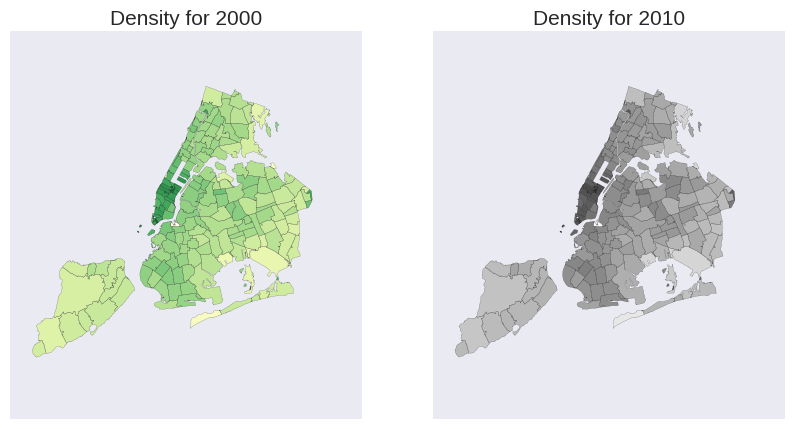

In [2312]:
fig = plt.figure(figsize = (10,5))
ax1 =fig.add_subplot(121)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
data_and_zip.plot(column='density00',colormap='YlGn',alpha=1,linewidth=0.1,ax=ax1)
plt.title("Density for 2000",fontsize =15)

ax2 = fig.add_subplot(122)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
data_and_zip.plot(column='density10',colormap='gray_r',alpha=1,linewidth=0.1,ax=ax2)
plt.title("Density for 2010",fontsize =15)

plt.show()

#### The right picture shows the density of business in 2000 on NYC map, the left picture shows the density of business in 2010 on NYC map. The two graphs shared much similarity, the density in Manhattan is much higher than other district, which make sense. And we alseo can find the density if business doesn't change a lot during the 10 years.

## (4) Collect census data from the 2010 and 2000 census and extract the estimate (mean or median) age, population, and diversity of each census tract. 
#### I used the SQL call in this method.

In [191]:
import urllib
import urllib2
from cStringIO import StringIO

### Get census tract file for 2000

In [197]:
SQL_SOURCE = 'https://fb55.carto.com/api/v2/sql'

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    """ queries a url with an sql compatible search
    Arguments:
    query : the sql query string
    format : the expected format
    source " the url of the API
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

In [199]:
facilityQuery = '''SELECT * FROM DEC_00_SF1_DP1 '''
    
facilityStream = queryCartoDB(facilityQuery, format='JSON')
facilityData   = json.loads(facilityStream.read())
facilityData
facilities     = pd.DataFrame.from_dict(facilityData['rows'])
facilities.head()

,cartodb_id,geo_display_label,geo_id,geo_id2,hc01_vc01,hc01_vc03,hc01_vc04,hc01_vc05,hc01_vc06,hc01_vc07,...,hc02_vc90,hc02_vc91,hc02_vc93,hc02_vc94,hc02_vc95,hc02_vc96,hc02_vc97,hc02_vc98,the_geom,the_geom_webmercator
0,1583,"Census Tract 543, Kings County, New York",1400000US36047054300,36047054300,0,0,0,0,0,0,...,(X),(X),,,,,(X),(X),None,None
1,3752,"Census Tract 1211, Queens County, New York",1400000US36081121100,36081121100,0,0,0,0,0,0,...,(X),(X),,,,,(X),(X),None,None
2,107,"Census Tract 37, Bronx County, New York",1400000US36005003700,36005003700,478,223,255,45,76,65,...,(X),(X),100.0,90.5,9.5,0.0,(X),(X),None,None
3,118,"Census Tract 49, Bronx County, New York",1400000US36005004900,36005004900,246,104,142,20,22,22,...,(X),(X),100.0,88.6,11.4,0.0,(X),(X),None,None
4,126,"Census Tract 58, Bronx County, New York",1400000US36005005800,36005005800,5,4,1,1,1,0,...,(X),(X),100.0,100.0,0.0,0.0,(X),(X),None,None


### Find the columns conain the age ,population and diveristy infomration for 2000

In [253]:
facilities['hc01_vc18'].head()

0     0.0
1     0.0
2    22.0
3    30.0
4    23.5
Name: hc01_vc18, dtype: object

In [202]:
len(facilities)

4907

In [881]:
cen2000 = facilities[['geo_id','geo_id2', 'hc01_vc01', 'hc02_vc29','hc01_vc18']]

In [882]:
cen2000.head()

,geo_id,geo_id2,hc01_vc01,hc02_vc29,hc01_vc18
0,1400000US36047054300,36047054300,0,,0.0
1,1400000US36081121100,36081121100,0,,0.0
2,1400000US36005003700,36005003700,478,18.4,22.0
3,1400000US36005004900,36005004900,246,20.7,30.0
4,1400000US36005005800,36005005800,5,0.0,23.5


In [883]:
cen2000=cen2000.rename(columns={'hc01_vc01':'population', 'hc02_vc29':'diversity', 'hc01_vc18':'age'})

In [884]:
cen2000.head()

,geo_id,geo_id2,population,diversity,age
0,1400000US36047054300,36047054300,0,,0.0
1,1400000US36081121100,36081121100,0,,0.0
2,1400000US36005003700,36005003700,478,18.4,22.0
3,1400000US36005004900,36005004900,246,20.7,30.0
4,1400000US36005005800,36005005800,5,0.0,23.5


### Get census tract file for 2010

In [254]:
facilityQuery1 = '''SELECT * FROM DEC_10_SF1_SF1DP1 '''
    
facilityStream1 = queryCartoDB(facilityQuery1, format='JSON')
facilityData1   = json.loads(facilityStream1.read())
facilities1     = pd.DataFrame.from_dict(facilityData1['rows'])
facilities1.head()

,cartodb_id,geo_display_label,geo_id,geo_id2,hd01_s001,hd01_s002,hd01_s003,hd01_s004,hd01_s005,hd01_s006,...,hd02_s119,hd02_s120,hd02_s121,hd02_s122,hd02_s123,hd02_s124,hd02_s125,hd02_s126,the_geom,the_geom_webmercator
0,3391,"Census Tract 383.01, Queens County, New York",1400000US36081038301,36081038301,0,0,0,0,0,0,...,,,,,,,,,None,None
1,97,"Census Tract 24, Bronx County, New York",1400000US36005002400,36005002400,4,0,0,0,0,1,...,0,0,0,0,0,0,0,0,None,None
2,2386,"Census Tract 9902, Nassau County, New York",1400000US36059990200,36059990200,0,0,0,0,0,0,...,,,,,,,,,None,None
3,2389,"Census Tract 9904, Nassau County, New York",1400000US36059990400,36059990400,0,0,0,0,0,0,...,,,,,,,,,None,None
4,462,"Census Tract 129, Broome County, New York",1400000US36007012900,36007012900,1532,36,52,55,72,57,...,0,0.2,0.2,99,97.5,0.3,0,0.7,None,None


### Find the columns conain the age ,population and diveristy infomration for 2010

In [302]:
facilities1['hd02_s078'].head()

0        
1      50
2        
3        
4    98.2
Name: hd02_s078, dtype: object

In [303]:
facilities1['hd01_s020'].head()

0       0
1      38
2       0
3       0
4    59.8
Name: hd01_s020, dtype: object

In [903]:
cen2010 = facilities1[['geo_id', 'geo_id2', 'hd01_s001', 'hd02_s078','hd01_s020']]

In [906]:
cen2010=cen2010.rename(columns={'hd01_s001':'population', 'hd02_s078':'diversity', 'hd01_s020':'age'})

In [907]:
cen2010.head()

,geo_id,geo_id2,population,diversity,age
0,1400000US36081038301,36081038301,0,,0
1,1400000US36005002400,36005002400,4,50,38
2,1400000US36059990200,36059990200,0,,0
3,1400000US36059990400,36059990400,0,,0
4,1400000US36007012900,36007012900,1532,98.2,59.8


## (5) Collect the income data by census tract from the income from American Fact Finder for the years 2010 and 2000 at the census tract level.

### Get Income census tract file for 2000

In [843]:
income00query = '''
SELECT *
FROM DEC_00_SF3_DP3_with_ann
'''

income00Stream = queryCartoDB(income00query, format='CSV')
income00     = pd.read_csv(income00Stream)

In [844]:
income00 = income00.replace('(X)',np.nan)

In [845]:
income00.head()

,cartodb_id,the_geom,the_geom_webmercator,geo_id,geo_id2,geo_display_label,hc01_vc02,hc02_vc02,hc01_vc03,hc02_vc03,hc01_vc04,hc02_vc04,hc01_vc05,hc02_vc05,hc01_vc06,hc02_vc06,hc01_vc07,hc02_vc07,hc01_vc08,hc02_vc08,hc01_vc09,hc02_vc09,hc01_vc10,hc02_vc10,hc01_vc11,hc02_vc11,hc01_vc12,hc02_vc12,hc01_vc13,hc02_vc13,hc01_vc14,hc02_vc14,hc01_vc15,hc02_vc15,hc01_vc17,hc02_vc17,hc01_vc18,hc02_vc18,hc01_vc19,hc02_vc19,hc01_vc20,hc02_vc20,hc01_vc21,hc02_vc21,hc01_vc22,hc02_vc22,hc01_vc23,hc02_vc23,hc01_vc24,hc02_vc24,hc01_vc25,hc02_vc25,hc01_vc27,hc02_vc27,hc01_vc28,hc02_vc28,hc01_vc29,hc02_vc29,hc01_vc30,hc02_vc30,hc01_vc31,hc02_vc31,hc01_vc32,hc02_vc32,hc01_vc34,hc02_vc34,hc01_vc35,hc02_vc35,hc01_vc36,hc02_vc36,hc01_vc37,hc02_vc37,hc01_vc38,hc02_vc38,hc01_vc39,hc02_vc39,hc01_vc40,hc02_vc40,hc01_vc41,hc02_vc41,hc01_vc42,hc02_vc42,hc01_vc43,hc02_vc43,hc01_vc44,hc02_vc44,hc01_vc45,hc02_vc45,hc01_vc46,hc02_vc46,hc01_vc48,hc02_vc48,hc01_vc49,hc02_vc49,hc01_vc50,hc02_vc50,hc01_vc51,hc02_vc51,hc01_vc53,hc02_vc53,hc01_vc54,hc02_vc54,hc01_vc55,hc02_vc55,hc01_vc56,hc02_vc56,hc01_vc57,hc02_vc57,hc01_vc58,hc02_vc58,hc01_vc59,hc02_vc59,hc01_vc60,hc02_vc60,hc01_vc61,hc02_vc61,hc01_vc62,hc02_vc62,hc01_vc63,hc02_vc63,hc01_vc64,hc02_vc64,hc01_vc65,hc02_vc65,hc01_vc66,hc02_vc66,hc01_vc67,hc02_vc67,hc01_vc68,hc02_vc68,hc01_vc69,hc02_vc69,hc01_vc70,hc02_vc70,hc01_vc71,hc02_vc71,hc01_vc72,hc02_vc72,hc01_vc73,hc02_vc73,hc01_vc74,hc02_vc74,hc01_vc75,hc02_vc75,hc01_vc76,hc02_vc76,hc01_vc77,hc02_vc77,hc01_vc78,hc02_vc78,hc01_vc79,hc02_vc79,hc01_vc80,hc02_vc80,hc01_vc81,hc02_vc81,hc01_vc82,hc02_vc82,hc01_vc83,hc02_vc83,hc01_vc84,hc02_vc84,hc01_vc85,hc02_vc85,hc01_vc86,hc02_vc86,hc01_vc87,hc02_vc87,hc01_vc89,hc02_vc89,hc01_vc90,hc02_vc90,hc01_vc92,hc02_vc92,hc01_vc93,hc02_vc93,hc01_vc94,hc02_vc94,hc01_vc95,hc02_vc95,hc01_vc96,hc02_vc96,hc01_vc97,hc02_vc97,hc01_vc98,hc02_vc98,hc01_vc99,hc02_vc99,hc01_vc100,hc02_vc100,hc01_vc101,hc02_vc101,hc01_vc102,hc02_vc102,hc01_vc103,hc02_vc103,hc01_vc104,hc02_vc104,hc01_vc105,hc02_vc105,hc01_vc106,hc02_vc106,hc01_vc107,hc02_vc107,hc01_vc108,hc02_vc108,hc01_vc109,hc02_vc109,hc01_vc110,hc02_vc110,hc01_vc111,hc02_vc111,hc01_vc112,hc02_vc112,hc01_vc113,hc02_vc113,hc01_vc114,hc02_vc114,hc01_vc115,hc02_vc115
0,4036,NaN,NaN,1400000US36089991900,36089991900,"Census Tract 9919, St. Lawrence County, New York",994,100.0,600,60.4,600,60.4,379,38.1,221,22.2,36.8,NaN,0,0.0,394,39.6,494,100.0,275,55.7,275,55.7,204,41.3,0,NaN,0,NaN,366,100.0,29,7.9,28,7.7,0,0.0,302,82.5,0,0.0,7,1.9,7.4,NaN,379,100.0,120,31.7,92,24.3,106,28.0,0,0.0,41,10.8,20,5.3,0,0.0,0,0.0,0,0.0,0,0.0,29,7.7,0,0.0,23,6.1,13,3.4,7,1.8,256,67.5,51,13.5,0,0.0,0,0.0,364,96.0,15,4.0,0,0.0,0,0.0,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,3540,NaN,8750,NaN,0,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN
1,41,NaN,NaN,1400000US36001013703,36001013703,"Census Tract 137.03, Albany County, New York",2719,100.0,1027,37.8,1027,37.8,994,36.6,33,1.2,3.2,NaN,0,0.0,1692,62.2,1290,100.0,460,35.7,460,35.7,446,34.6,89,100.0,85,95.5,974,100.0,840,86.2,40,4.1,21,2.2,13,1.3,0,0.0,60,6.2,19.5,NaN,994,100.0,461,46.4,118,11.9,255,25.7,0,0.0,87,8.8,73,7.3,19,1.9,81,8.1,45,4.5,58,5.8,70,7.0,33,3.3,53,5.3,67,6.7,87,8.8,155,15.6,90,9.1,78,7.8,158,15.9,631,63.5,244,24.5,119,12.0,0,0.0,686,100.0,29,4.2,20,2.9,27,3.9,45,6.6,64,9.3,189,27.6,76,11.1,166,24.2,27,3.9,43,6.3,68929,NaN,600,87.5,84066,NaN,171,24.9,13375,NaN,12,1.7,3833,NaN,0,0.0,NaN,NaN,148,21.6,24181,NaN,537,100.0,13,2.4,15,2.8,0,0.0,39,7.3,38,7.1,142,26.4,68,12.7,160,29.8,19,3.5,43,8.0,78764,NaN,25009,NaN,50449,NaN,37083,NaN,13,NaN,NaN,2.4,5,NaN,NaN,2.9,0,NaN,NaN,0.0,0,NaN,NaN,0.0,0,NaN,NaN,0.0,0,NaN,NaN,NaN,68,NaN,NaN,3.9,60,NaN,NaN,4.3,16,NaN,NaN,9

In [846]:
income00[income00['geo_id']=='1400000US36001001901']

,cartodb_id,the_geom,the_geom_webmercator,geo_id,geo_id2,geo_display_label,hc01_vc02,hc02_vc02,hc01_vc03,hc02_vc03,hc01_vc04,hc02_vc04,hc01_vc05,hc02_vc05,hc01_vc06,hc02_vc06,hc01_vc07,hc02_vc07,hc01_vc08,hc02_vc08,hc01_vc09,hc02_vc09,hc01_vc10,hc02_vc10,hc01_vc11,hc02_vc11,hc01_vc12,hc02_vc12,hc01_vc13,hc02_vc13,hc01_vc14,hc02_vc14,hc01_vc15,hc02_vc15,hc01_vc17,hc02_vc17,hc01_vc18,hc02_vc18,hc01_vc19,hc02_vc19,hc01_vc20,hc02_vc20,hc01_vc21,hc02_vc21,hc01_vc22,hc02_vc22,hc01_vc23,hc02_vc23,hc01_vc24,hc02_vc24,hc01_vc25,hc02_vc25,hc01_vc27,hc02_vc27,hc01_vc28,hc02_vc28,hc01_vc29,hc02_vc29,hc01_vc30,hc02_vc30,hc01_vc31,hc02_vc31,hc01_vc32,hc02_vc32,hc01_vc34,hc02_vc34,hc01_vc35,hc02_vc35,hc01_vc36,hc02_vc36,hc01_vc37,hc02_vc37,hc01_vc38,hc02_vc38,hc01_vc39,hc02_vc39,hc01_vc40,hc02_vc40,hc01_vc41,hc02_vc41,hc01_vc42,hc02_vc42,hc01_vc43,hc02_vc43,hc01_vc44,hc02_vc44,hc01_vc45,hc02_vc45,hc01_vc46,hc02_vc46,hc01_vc48,hc02_vc48,hc01_vc49,hc02_vc49,hc01_vc50,hc02_vc50,hc01_vc51,hc02_vc51,hc01_vc53,hc02_vc53,hc01_vc54,hc02_vc54,hc01_vc55,hc02_vc55,hc01_vc56,hc02_vc56,hc01_vc57,hc02_vc57,hc01_vc58,hc02_vc58,hc01_vc59,hc02_vc59,hc01_vc60,hc02_vc60,hc01_vc61,hc02_vc61,hc01_vc62,hc02_vc62,hc01_vc63,hc02_vc63,hc01_vc64,hc02_vc64,hc01_vc65,hc02_vc65,hc01_vc66,hc02_vc66,hc01_vc67,hc02_vc67,hc01_vc68,hc02_vc68,hc01_vc69,hc02_vc69,hc01_vc70,hc02_vc70,hc01_vc71,hc02_vc71,hc01_vc72,hc02_vc72,hc01_vc73,hc02_vc73,hc01_vc74,hc02_vc74,hc01_vc75,hc02_vc75,hc01_vc76,hc02_vc76,hc01_vc77,hc02_vc77,hc01_vc78,hc02_vc78,hc01_vc79,hc02_vc79,hc01_vc80,hc02_vc80,hc01_vc81,hc02_vc81,hc01_vc82,hc02_vc82,hc01_vc83,hc02_vc83,hc01_vc84,hc02_vc84,hc01_vc85,hc02_vc85,hc01_vc86,hc02_vc86,hc01_vc87,hc02_vc87,hc01_vc89,hc02_vc89,hc01_vc90,hc02_vc90,hc01_vc92,hc02_vc92,hc01_vc93,hc02_vc93,hc01_vc94,hc02_vc94,hc01_vc95,hc02_vc95,hc01_vc96,hc02_vc96,hc01_vc97,hc02_vc97,hc01_vc98,hc02_vc98,hc01_vc99,hc02_vc99,hc01_vc100,hc02_vc100,hc01_vc101,hc02_vc101,hc01_vc102,hc02_vc102,hc01_vc103,hc02_vc103,hc01_vc104,hc02_vc104,hc01_vc105,hc02_vc105,hc01_vc106,hc02_vc106,hc01_vc107,hc02_vc107,hc01_vc108,hc02_vc108,hc01_vc109,hc02_vc109,hc01_vc110,hc02_vc110,hc01_vc111,hc02_vc111,hc01_vc112,hc02_vc112,hc01_vc113,hc02_vc113,hc01_vc114,hc02_vc114,hc01_vc115,hc02_vc115
101,19,NaN,NaN,1400000US36001001901,36001001901,"Census Tract 19.01, Albany County, New York",2202,100.0,1464,66.5,1448,65.8,1411,64.1,37,1.7,2.6,NaN,16,0.7,738,33.5,1260,100.0,770,61.1,760,60.3,748,59.4,132,100.0,82,62.1,1386,100.0,929,67.0,226,16.3,114,8.2,83,6.0,5,0.4,29,2.1,18.8,NaN,1411,100.0,766,54.3,182,12.9,395,28.0,0,0.0,45,3.2,23,1.6,0,0.0,16,1.1,24,1.7,21,1.5,113,8.0,18,1.3,39,2.8,165,11.7,121,8.6,460,32.6,93,6.6,100,7.1,241,17.1,865,61.3,457,32.4,89,6.3,0,0.0,1216,100.0,88,7.2,41,3.4,109,9.0,98,8.1,236,19.4,352,28.9,187,15.4,87,7.2,12,1.0,6,0.5,52093,NaN,946,77.8,57012,NaN,350,28.8,12163,NaN,5,0.4,7200,NaN,5,0.4,4800,NaN,274,22.5,17687,NaN,629,100.0,0,0.0,6,1.0,35,5.6,47,7.5,94,14.9,231,36.7,144,22.9,60,9.5,12,1.9,0,0.0,65208,NaN,25474,NaN,37422,NaN,35697,NaN,0,NaN,NaN,0.0,0,NaN,NaN,0.0,0,NaN,NaN,0.0,0,NaN,NaN,0.0,0,NaN,NaN,0.0,0,NaN,NaN,NaN,153,NaN,NaN,5.8,145,NaN,NaN,6.8,13,NaN,NaN,3.3,0,NaN,NaN,0.0,0,NaN,NaN,0.0,153,NaN,NaN,18.8


In [847]:
income00[income00['geo_id']=='1400000US36029013800']

,cartodb_id,the_geom,the_geom_webmercator,geo_id,geo_id2,geo_display_label,hc01_vc02,hc02_vc02,hc01_vc03,hc02_vc03,hc01_vc04,hc02_vc04,hc01_vc05,hc02_vc05,hc01_vc06,hc02_vc06,hc01_vc07,hc02_vc07,hc01_vc08,hc02_vc08,hc01_vc09,hc02_vc09,hc01_vc10,hc02_vc10,hc01_vc11,hc02_vc11,hc01_vc12,hc02_vc12,hc01_vc13,hc02_vc13,hc01_vc14,hc02_vc14,hc01_vc15,hc02_vc15,hc01_vc17,hc02_vc17,hc01_vc18,hc02_vc18,hc01_vc19,hc02_vc19,hc01_vc20,hc02_vc20,hc01_vc21,hc02_vc21,hc01_vc22,hc02_vc22,hc01_vc23,hc02_vc23,hc01_vc24,hc02_vc24,hc01_vc25,hc02_vc25,hc01_vc27,hc02_vc27,hc01_vc28,hc02_vc28,hc01_vc29,hc02_vc29,hc01_vc30,hc02_vc30,hc01_vc31,hc02_vc31,hc01_vc32,hc02_vc32,hc01_vc34,hc02_vc34,hc01_vc35,hc02_vc35,hc01_vc36,hc02_vc36,hc01_vc37,hc02_vc37,hc01_vc38,hc02_vc38,hc01_vc39,hc02_vc39,hc01_vc40,hc02_vc40,hc01_vc41,hc02_vc41,hc01_vc42,hc02_vc42,hc01_vc43,hc02_vc43,hc01_vc44,hc02_vc44,hc01_vc45,hc02_vc45,hc01_vc46,hc02_vc46,hc01_vc48,hc02_vc48,hc01_vc49,hc02_vc49,hc01_vc50,hc02_vc50,hc01_vc51,hc02_vc51,hc01_vc53,hc02_vc53,hc01_vc54,hc02_vc54,hc01_vc55,hc02_vc55,hc01_vc56,hc02_vc56,hc01_vc57,hc02_vc57,hc01_vc58,hc02_vc58,hc01_vc59,hc02_vc59,hc01_vc60,hc02_vc60,hc01_vc61,hc02_vc61,hc01_vc62,hc02_vc62,hc01_vc63,hc02_vc63,hc01_vc64,hc02_vc64,hc01_vc65,hc02_vc65,hc01_vc66,hc02_vc66,hc01_vc67,hc02_vc67,hc01_vc68,hc02_vc68,hc01_vc69,hc02_vc69,hc01_vc70,hc02_vc70,hc01_vc71,hc02_vc71,hc01_vc72,hc02_vc72,hc01_vc73,hc02_vc73,hc01_vc74,hc02_vc74,hc01_vc75,hc02_vc75,hc01_vc76,hc02_vc76,hc01_vc77,hc02_vc77,hc01_vc78,hc02_vc78,hc01_vc79,hc02_vc79,hc01_vc80,hc02_vc80,hc01_vc81,hc02_vc81,hc01_vc82,hc02_vc82,hc01_vc83,hc02_vc83,hc01_vc84,hc02_vc84,hc01_vc85,hc02_vc85,hc01_vc86,hc02_vc86,hc01_vc87,hc02_vc87,hc01_vc89,hc02_vc89,hc01_vc90,hc02_vc90,hc01_vc92,hc02_vc92,hc01_vc93,hc02_vc93,hc01_vc94,hc02_vc94,hc01_vc95,hc02_vc95,hc01_vc96,hc02_vc96,hc01_vc97,hc02_vc97,hc01_vc98,hc02_vc98,hc01_vc99,hc02_vc99,hc01_vc100,hc02_vc100,hc01_vc101,hc02_vc101,hc01_vc102,hc02_vc102,hc01_vc103,hc02_vc103,hc01_vc104,hc02_vc104,hc01_vc105,hc02_vc105,hc01_vc106,hc02_vc106,hc01_vc107,hc02_vc107,hc01_vc108,hc02_vc108,hc01_vc109,hc02_vc109,hc01_vc110,hc02_vc110,hc01_vc111,hc02_vc111,hc01_vc112,hc02_vc112,hc01_vc113,hc02_vc113,hc01_vc114,hc02_vc114,hc01_vc115,hc02_vc115
1010,940,NaN,NaN,1400000US36029013800,36029013800,"Census Tract 138, Erie County, New York",5933,100.0,3818,64.4,3818,64.4,3661,61.7,157,2.6,4.1,NaN,0,0.0,2115,35.6,2959,100.0,1668,56.4,1668,56.4,1589,53.7,550,100.0,277,50.4,3590,100.0,3104,86.5,282,7.9,5,0.1,64,1.8,8,0.2,127,3.5,24.8,NaN,3661,100.0,1650,45.1,385,10.5,842,23.0,0,0.0,383,10.5,401,11.0,21,0.6,264,7.2,579,15.8,141,3.9,375,10.2,191,5.2,131,3.6,176,4.8,295,8.1,919,25.1,277,7.6,136,3.7,156,4.3,2849,77.8,575,15.7,221,6.0,16,0.4,2990,100.0,106,3.5,198,6.6,247,8.3,351,11.7,424,14.2,644,21.5,509,17.0,380,12.7,51,1.7,80,2.7,55842,NaN,2374,79.4,61279,NaN,960,32.1,13540,NaN,57,1.9,6814,NaN,14,0.5,536,NaN,684,22.9,21320,NaN,2199,100.0,67,3.0,33,1.5,91,4.1,224,10.2,316,14.4,529,24.1,449,20.4,368,16.7,51,2.3,71,3.2,65576,NaN,25668,NaN,47417,NaN,24988,NaN,67,NaN,NaN,3.0,67,NaN,NaN,6.4,28,NaN,NaN,8.2,22,NaN,NaN,14.3,22,NaN,NaN,21.4,22,NaN,NaN,100.0,336,NaN,NaN,4.4,214,NaN,NaN,3.8,17,NaN,NaN,1.5,106,NaN,NaN,5.6,67,NaN,NaN,4.6,136,NaN,NaN,13.1


In [888]:
income2000 = income00[['geo_id','hc01_vc65']]

In [889]:
income2000.head(2)

,geo_id,hc01_vc65
0,1400000US36089991900,0
1,1400000US36001013703,600


In [890]:
income2000=income2000.rename(columns={'hc01_vc65':'income'})

In [891]:
income2000.head()

,geo_id,income
0,1400000US36089991900,0
1,1400000US36001013703,600
2,1400000US36005000200,857
3,1400000US36005002400,0
4,1400000US36029001301,0


### Get Income census tract file for 2010

In [892]:
income10query = '''
SELECT *
FROM ACS_10_5YR_S1901_with_ann
'''

income10Stream = queryCartoDB(income10query, format='CSV')
income10     = pd.read_csv(income10Stream)

In [798]:
income10[income10['geo_id'] == '1400000US36047053700']

,cartodb_id,the_geom,the_geom_webmercator,geo_id,geo_id2,geo_display_label,hc01_est_vc01,hc01_moe_vc01,hc02_est_vc01,hc02_moe_vc01,hc03_est_vc01,hc03_moe_vc01,hc04_est_vc01,hc04_moe_vc01,hc01_est_vc02,hc01_moe_vc02,hc02_est_vc02,hc02_moe_vc02,hc03_est_vc02,hc03_moe_vc02,hc04_est_vc02,hc04_moe_vc02,hc01_est_vc03,hc01_moe_vc03,hc02_est_vc03,hc02_moe_vc03,hc03_est_vc03,hc03_moe_vc03,hc04_est_vc03,hc04_moe_vc03,hc01_est_vc04,hc01_moe_vc04,hc02_est_vc04,hc02_moe_vc04,hc03_est_vc04,hc03_moe_vc04,hc04_est_vc04,hc04_moe_vc04,hc01_est_vc05,hc01_moe_vc05,hc02_est_vc05,hc02_moe_vc05,hc03_est_vc05,hc03_moe_vc05,hc04_est_vc05,hc04_moe_vc05,hc01_est_vc06,hc01_moe_vc06,hc02_est_vc06,hc02_moe_vc06,hc03_est_vc06,hc03_moe_vc06,hc04_est_vc06,hc04_moe_vc06,hc01_est_vc07,hc01_moe_vc07,hc02_est_vc07,hc02_moe_vc07,hc03_est_vc07,hc03_moe_vc07,hc04_est_vc07,hc04_moe_vc07,hc01_est_vc08,hc01_moe_vc08,hc02_est_vc08,hc02_moe_vc08,hc03_est_vc08,hc03_moe_vc08,hc04_est_vc08,hc04_moe_vc08,hc01_est_vc09,hc01_moe_vc09,hc02_est_vc09,hc02_moe_vc09,hc03_est_vc09,hc03_moe_vc09,hc04_est_vc09,hc04_moe_vc09,hc01_est_vc10,hc01_moe_vc10,hc02_est_vc10,hc02_moe_vc10,hc03_est_vc10,hc03_moe_vc10,hc04_est_vc10,hc04_moe_vc10,hc01_est_vc11,hc01_moe_vc11,hc02_est_vc11,hc02_moe_vc11,hc03_est_vc11,hc03_moe_vc11,hc04_est_vc11,hc04_moe_vc11,hc01_est_vc13,hc01_moe_vc13,hc02_est_vc13,hc02_moe_vc13,hc03_est_vc13,hc03_moe_vc13,hc04_est_vc13,hc04_moe_vc13,hc01_est_vc15,hc01_moe_vc15,hc02_est_vc15,hc02_moe_vc15,hc03_est_vc15,hc03_moe_vc15,hc04_est_vc15,hc04_moe_vc15,hc01_est_vc18,hc01_moe_vc18,hc02_est_vc18,hc02_moe_vc18,hc03_est_vc18,hc03_moe_vc18,hc04_est_vc18,hc04_moe_vc18,hc01_est_vc19,hc01_moe_vc19,hc02_est_vc19,hc02_moe_vc19,hc03_est_vc19,hc03_moe_vc19,hc04_est_vc19,hc04_moe_vc19,hc01_est_vc20,hc01_moe_vc20,hc02_est_vc20,hc02_moe_vc20,hc03_est_vc20,hc03_moe_vc20,hc04_est_vc20,hc04_moe_vc20
1557,1558,NaN,NaN,1400000US36047053700,36047053700,"Census Tract 537, Kings County, New York",670,45,670,45,604,71,0,123,14.0,9.5,14.0,9.5,9.4,8.2,0.0,**,12.1,8.0,12.1,8.0,13.4,8.7,0.0,**,19.3,10.6,19.3,10.6,21.4,11.7,0.0,**,10.0,8.4,10.0,8.4,11.1,9.2,0.0,**,15.5,8.4,15.5,8.4,13.7,7.4,0.0,**,15.8,8.9,15.8,8.9,16.2,10.0,0.0,**,9.9,7.2,9.9,7.2,10.9,8.0,0.0,**,3.4,4.1,3.4,4.1,3.8,4.5,0.0,**,0.0,5.1,0.0,5.1,0.0,5.6,0.0,**,0.0,5.1,0.0,5.1,0.0,5.6,0.0,**,30938,14132,30938,14132,31354.0,12394,-,**,36910,6693,36910,6693,False,N,-,**,60.0,(X),(X),(X),(X),(X),(X),(X),(X),(X),60.0,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),0.0,(X)


In [799]:
income10[income10['geo_id'] == '1400000US36029014803']

,cartodb_id,the_geom,the_geom_webmercator,geo_id,geo_id2,geo_display_label,hc01_est_vc01,hc01_moe_vc01,hc02_est_vc01,hc02_moe_vc01,hc03_est_vc01,hc03_moe_vc01,hc04_est_vc01,hc04_moe_vc01,hc01_est_vc02,hc01_moe_vc02,hc02_est_vc02,hc02_moe_vc02,hc03_est_vc02,hc03_moe_vc02,hc04_est_vc02,hc04_moe_vc02,hc01_est_vc03,hc01_moe_vc03,hc02_est_vc03,hc02_moe_vc03,hc03_est_vc03,hc03_moe_vc03,hc04_est_vc03,hc04_moe_vc03,hc01_est_vc04,hc01_moe_vc04,hc02_est_vc04,hc02_moe_vc04,hc03_est_vc04,hc03_moe_vc04,hc04_est_vc04,hc04_moe_vc04,hc01_est_vc05,hc01_moe_vc05,hc02_est_vc05,hc02_moe_vc05,hc03_est_vc05,hc03_moe_vc05,hc04_est_vc05,hc04_moe_vc05,hc01_est_vc06,hc01_moe_vc06,hc02_est_vc06,hc02_moe_vc06,hc03_est_vc06,hc03_moe_vc06,hc04_est_vc06,hc04_moe_vc06,hc01_est_vc07,hc01_moe_vc07,hc02_est_vc07,hc02_moe_vc07,hc03_est_vc07,hc03_moe_vc07,hc04_est_vc07,hc04_moe_vc07,hc01_est_vc08,hc01_moe_vc08,hc02_est_vc08,hc02_moe_vc08,hc03_est_vc08,hc03_moe_vc08,hc04_est_vc08,hc04_moe_vc08,hc01_est_vc09,hc01_moe_vc09,hc02_est_vc09,hc02_moe_vc09,hc03_est_vc09,hc03_moe_vc09,hc04_est_vc09,hc04_moe_vc09,hc01_est_vc10,hc01_moe_vc10,hc02_est_vc10,hc02_moe_vc10,hc03_est_vc10,hc03_moe_vc10,hc04_est_vc10,hc04_moe_vc10,hc01_est_vc11,hc01_moe_vc11,hc02_est_vc11,hc02_moe_vc11,hc03_est_vc11,hc03_moe_vc11,hc04_est_vc11,hc04_moe_vc11,hc01_est_vc13,hc01_moe_vc13,hc02_est_vc13,hc02_moe_vc13,hc03_est_vc13,hc03_moe_vc13,hc04_est_vc13,hc04_moe_vc13,hc01_est_vc15,hc01_moe_vc15,hc02_est_vc15,hc02_moe_vc15,hc03_est_vc15,hc03_moe_vc15,hc04_est_vc15,hc04_moe_vc15,hc01_est_vc18,hc01_moe_vc18,hc02_est_vc18,hc02_moe_vc18,hc03_est_vc18,hc03_moe_vc18,hc04_est_vc18,hc04_moe_vc18,hc01_est_vc19,hc01_moe_vc19,hc02_est_vc19,hc02_moe_vc19,hc03_est_vc19,hc03_moe_vc19,hc04_est_vc19,hc04_moe_vc19,hc01_est_vc20,hc01_moe_vc20,hc02_est_vc20,hc02_moe_vc20,hc03_est_vc20,hc03_moe_vc20,hc04_est_vc20,hc04_moe_vc20
934,935,NaN,NaN,1400000US36029014803,36029014803,"Census Tract 148.03, Erie County, New York",2350,154,1542,126,1372,136,808,178,1.9,1.8,0.0,2.2,0.0,2.5,5.4,5.3,3.7,2.5,2.4,2.3,2.7,2.6,6.1,5.5,9.7,3.4,7.1,3.7,5.5,3.3,16.3,8.8,15.0,5.0,10.8,4.4,10.9,4.5,23.1,11.6,13.7,4.8,14.1,5.6,11.9,5.1,14.7,8.3,22.6,5.2,23.7,7.0,23.0,7.4,19.9,8.9,17.4,5.0,22.3,7.1,25.1,7.9,6.6,5.3,10.5,3.5,13.7,5.2,14.5,5.5,4.3,4.0,3.0,2.4,3.6,3.4,4.1,3.8,1.9,3.1,2.6,2.0,2.1,2.2,2.4,2.4,1.6,3.5,58455,4958,70600,6193,72133.0,6982,32321,12637,65412,5621,72992,6320,False,N,46096,9695,31.7,(X),(X),(X),(X),(X),(X),(X),(X),(X),30.9,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),33.3,(X)


In [893]:
income10 = income10[['geo_id', 'hc01_est_vc01']]

In [894]:
income10.head()

,geo_id,hc01_est_vc01
0,1400000US36001000100,848
1,1400000US36001000200,2241
2,1400000US36001000300,2594
3,1400000US36001000401,1062
4,1400000US36001000403,2289


In [895]:
income2010 = income10.rename(columns={'hc01_est_vc01':'income'})

In [896]:
income2010.head(2)

,geo_id,income
0,1400000US36001000100,848
1,1400000US36001000200,2241


In [1000]:
data00 = pd.merge(cen2000, income2000, on = 'geo_id', how = 'inner')

## (6) Merge the datasets for each year and show a the tables containing the relevant data: the features and whatever else you need to identify and plot the data.

### Generated dataframe for 2000

In [1001]:
data00.head()

,geo_id,geo_id2,population,diversity,age,income
0,1400000US36047054300,36047054300,0,,0.0,0
1,1400000US36081121100,36081121100,0,,0.0,0
2,1400000US36005003700,36005003700,478,18.4,22.0,104
3,1400000US36005004900,36005004900,246,20.7,30.0,33
4,1400000US36005005800,36005005800,5,0.0,23.5,0


In [675]:
pd.set_option('display.max_columns', None)

In [1097]:
data10 = pd.merge(cen2010, income2010, on = 'geo_id', how = 'inner')

### Generated dataframe for 2000

In [1098]:
data10.head()

,geo_id,geo_id2,population,diversity,age,income
0,1400000US36081038301,36081038301,0,,0,0
1,1400000US36005002400,36005002400,4,50,38,0
2,1400000US36059990200,36059990200,0,,0,0
3,1400000US36059990400,36059990400,0,,0,0
4,1400000US36007012900,36007012900,1532,98.2,59.8,521


In [1161]:
url = "http://cosmo.nyu.edu/~fb55/PUI2016/data/census00_final.json"
response = urllib2.urlopen(url)
data = response.read().decode("utf-8")
data = json.loads(data)
data0 = pd.DataFrame(data)

In [1162]:
data0.head()

,age,diversity,geo_id,income,population
0,0.0,NaN,1400000US36047054300,NaN,0
1,0.0,NaN,1400000US36081121100,NaN,0
10,47.5,34.0,1400000US36029001401,18125.0,106
100,39.3,89.2,1400000US36001001901,52093.0,2656
1000,40.9,98.7,1400000US36029013800,55842.0,7663


In [1163]:
url = "http://cosmo.nyu.edu/~fb55/PUI2016/data/census10_final.json"
response = urllib2.urlopen(url)
data = response.read().decode("utf-8")
data = json.loads(data)
data1 = pd.DataFrame(data)

In [1164]:
data1.head()

,age,diversity,geo_id,income,population
0,0.0,NaN,1400000US36081038301,NaN,0
1,38.0,50.0,1400000US36005002400,NaN,4
10,16.4,98.7,1400000US36047053700,30938.0,3575
100,33.5,82.4,1400000US36001013300,40513.0,4427
1000,44.5,97.4,1400000US36029014803,58455.0,6028


## (7) Merge the df with the census tracts shapefile and display each of your features as a choropleth for both 2010 and 2000, and show the difference in the features as a third choroplath.

In [1355]:
path = os.getenv("PUIDATA")
ct_shape = gp.GeoDataFrame.from_file(path + "/table_2010_census_tracts.shp")
ct_shape.crs = from_epsg(2263)
ct_latlon = ct_shape.to_crs(epsg=4326)

In [1364]:
ct_shape.head(2)

,boro_code,boro_ct_20,boro_name,cartodb_id,cdeligibil,ct_2010,ctlabel,geometry,ntacode,ntaname,puma,shape_area,shape_leng
0,3,3050804,Brooklyn,998,E,050804,508.04,POLYGON ((-73.96140739646273 40.65216985809441...,BK42,Flatbush,4015,1110945.63082,4305.94762341
1,3,3027500,Brooklyn,1261,I,027500,275,POLYGON ((-73.93500821720123 40.68276376800321...,BK35,Stuyvesant Heights,4003,1743574.56294,5390.78775209


In [1365]:
countyID = {'Bronx':'005',
           'Manhattan':'061',
           'Staten Island':'085',
           'Brooklyn':'047',
           'Queens':'081'}

In [1366]:
ct_shape['allcodes'] = list(zip(ct_shape.boro_name, ct_shape.ct_2010))
ct_shape['geo_id']  = ct_shape[['allcodes']].applymap(lambda x: 
                            ("1400000US36%03d%06d"%(int(countyID[x[0]]),int(x[1]))))

In [1367]:
ct_shape.head()

,boro_code,boro_ct_20,boro_name,cartodb_id,cdeligibil,ct_2010,ctlabel,geometry,ntacode,ntaname,puma,shape_area,shape_leng,allcodes,geo_id
0,3,3050804,Brooklyn,998,E,050804,508.04,POLYGON ((-73.96140739646273 40.65216985809441...,BK42,Flatbush,4015,1110945.63082,4305.94762341,"(Brooklyn, 050804)",1400000US36047050804
1,3,3027500,Brooklyn,1261,I,027500,275,POLYGON ((-73.93500821720123 40.68276376800321...,BK35,Stuyvesant Heights,4003,1743574.56294,5390.78775209,"(Brooklyn, 027500)",1400000US36047027500
2,2,2009200,Bronx,1294,E,009200,92,POLYGON ((-73.84727881647562 40.82931474518224...,BX59,Westchester-Unionport,3709,3278193.62083,9143.90356952,"(Bronx, 009200)",1400000US36005009200
3,4,4099100,Queens,1306,I,099100,991,POLYGON ((-73.79179280404088 40.78935161609342...,QN49,Whitestone,4103,11557974.9909,17092.0365078,"(Queens, 099100)",1400000US36081099100
4,4,4000100,Queens,1407,I,000100,1,POLYGON ((-73.94911295133423 40.75452361982126...,QN31,Hunters Point-Sunnyside-West Maspeth,4109,12286326.8522,40345.5358859,"(Queens, 000100)",1400000US36081000100


In [2419]:
data0_geo = pd.merge(ct_shape, data0, on = 'geo_id', how = 'inner')
data0_geo.head()

,boro_code,boro_ct_20,boro_name,cartodb_id,cdeligibil,ct_2010,ctlabel,geometry,ntacode,ntaname,puma,shape_area,shape_leng,allcodes,geo_id,age,diversity,income,population
0,3,3027500,Brooklyn,1261,I,027500,275,POLYGON ((-73.93500821720123 40.68276376800321...,BK35,Stuyvesant Heights,4003,1743574.56294,5390.78775209,"(Brooklyn, 027500)",1400000US36047027500,33.9,1.5,30241.0,4171
1,2,2009200,Bronx,1294,E,009200,92,POLYGON ((-73.84727881647562 40.82931474518224...,BX59,Westchester-Unionport,3709,3278193.62083,9143.90356952,"(Bronx, 009200)",1400000US36005009200,31.7,30.1,36589.0,4877
2,4,4099100,Queens,1306,I,099100,991,POLYGON ((-73.79179280404088 40.78935161609342...,QN49,Whitestone,4103,11557974.9909,17092.0365078,"(Queens, 099100)",1400000US36081099100,47.1,87.7,62341.0,6659
3,4,4000100,Queens,1407,I,000100,1,POLYGON ((-73.94911295133423 40.75452361982126...,QN31,Hunters Point-Sunnyside-West Maspeth,4109,12286326.8522,40345.5358859,"(Queens, 000100)",1400000US36081000100,41.3,55.4,85898.0,1370
4,3,3024100,Brooklyn,1425,E,024100,241,POLYGON ((-73.95146465503193 40.68986334179581...,BK75,Bedford,4003,1939949.84007,5837.00532323,"(Brooklyn, 024100)",1400000US36047024100,36.2,10.4,10500.0,1564


In [1214]:
data10_geo = pd.merge(ct_shape, data10, on = 'geo_id', how = 'inner')
data10_geo.head()

,boro_code,boro_ct_20,boro_name,cartodb_id,cdeligibil,ct_2010,ctlabel,geometry,ntacode,ntaname,puma,shape_area,shape_leng,allcodes,geo_id,geo_id2,population,diversity,age,income
0,3,3050804,Brooklyn,998,E,050804,508.04,POLYGON ((-73.96140739646273 40.65216985809441...,BK42,Flatbush,4015,1110945.63082,4305.94762341,"(Brooklyn, 050804)",1400000US36047050804,36047050804,6250,15.5,32.7,2294
1,3,3027500,Brooklyn,1261,I,027500,275,POLYGON ((-73.93500821720123 40.68276376800321...,BK35,Stuyvesant Heights,4003,1743574.56294,5390.78775209,"(Brooklyn, 027500)",1400000US36047027500,36047027500,4180,9.1,35.6,1538
2,2,2009200,Bronx,1294,E,009200,92,POLYGON ((-73.84727881647562 40.82931474518224...,BX59,Westchester-Unionport,3709,3278193.62083,9143.90356952,"(Bronx, 009200)",1400000US36005009200,36005009200,5017,29.5,33.3,1598
3,4,4099100,Queens,1306,I,099100,991,POLYGON ((-73.79179280404088 40.78935161609342...,QN49,Whitestone,4103,11557974.9909,17092.0365078,"(Queens, 099100)",1400000US36081099100,36081099100,6507,85.5,51.1,2945
4,4,4000100,Queens,1407,I,000100,1,POLYGON ((-73.94911295133423 40.75452361982126...,QN31,Hunters Point-Sunnyside-West Maspeth,4109,12286326.8522,40345.5358859,"(Queens, 000100)",1400000US36081000100,36081000100,4949,63.5,32.4,1652


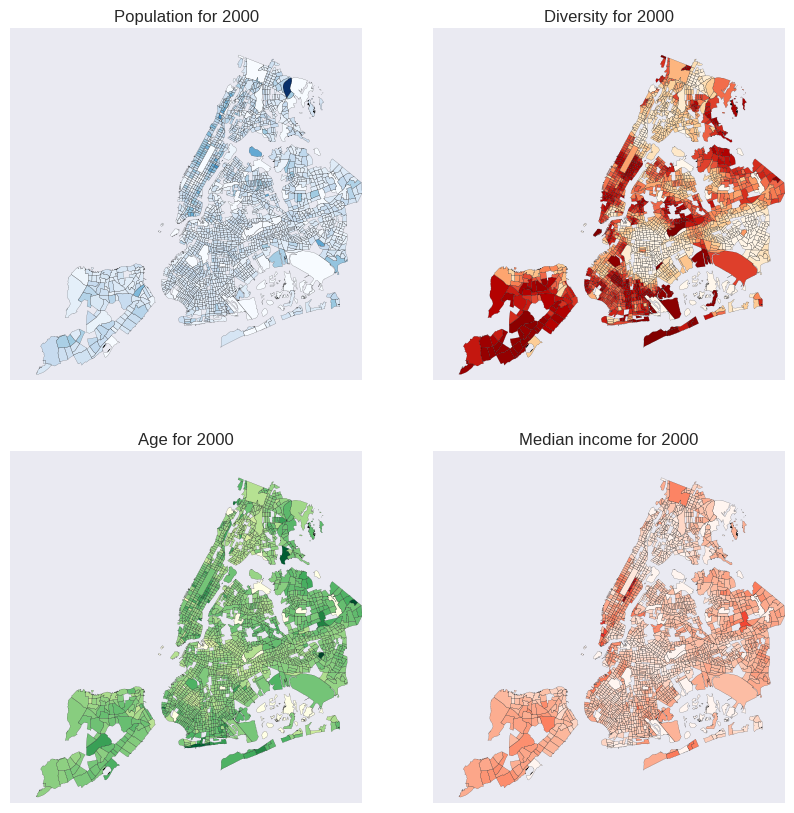

In [2314]:
fig = plt.figure(figsize = (10,10))
ax1 =fig.add_subplot(221)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
data0_geo.plot(column='population',colormap='Blues',alpha=1,linewidth=0.1,ax=ax1)
plt.title("Population for 2000",fontsize =12)

ax2 = fig.add_subplot(222)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
data0_geo.plot(column='diversity',colormap='OrRd',alpha=1,linewidth=0.1,ax=ax2)
plt.title("Diversity for 2000",fontsize =12)

ax3 =fig.add_subplot(223)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
data0_geo.plot(column='age',colormap='YlGn',alpha=1,linewidth=0.1,ax=ax3)
plt.title("Age for 2000",fontsize =12)

ax4 = fig.add_subplot(224)
ax4.get_xaxis().set_visible(False)
ax4.get_yaxis().set_visible(False)
data0_geo.plot(column='income',colormap='Reds',alpha=1,linewidth=0.1,ax=ax4)
plt.title("Median income for 2000",fontsize =12)

plt.show()

#### The four graphs show the pattern of 4 features in 2000 on NYC map, we can see that the population and age features do not have singnificat reginal diference which the income and diversity have obivious difference reginally. Pople in manhattan has higher median income also the diversity is higher.

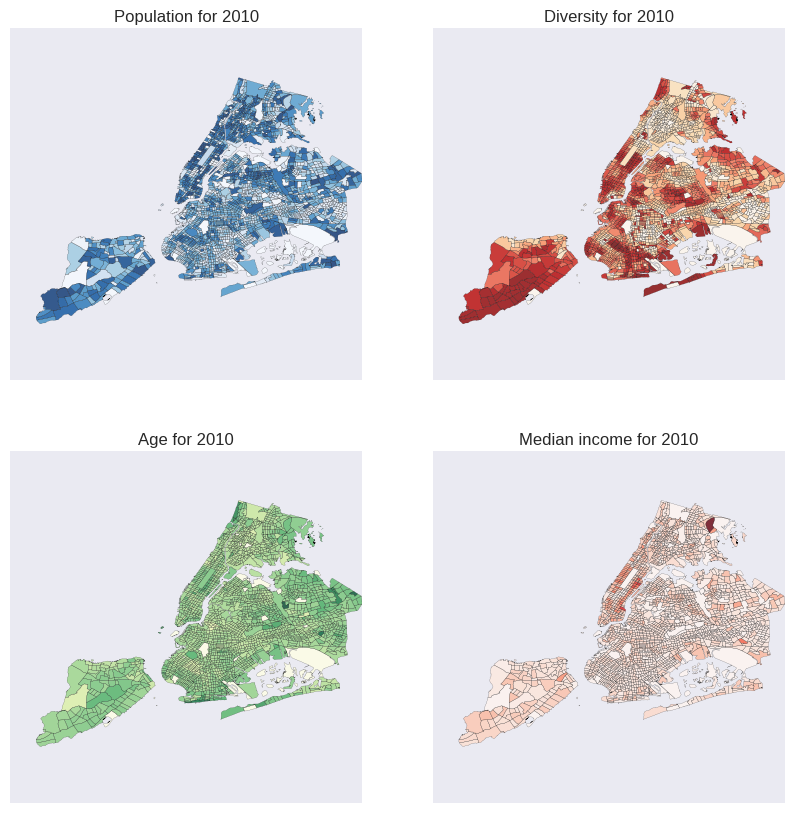

In [2315]:
fig = plt.figure(figsize = (10,10))
ax1 =fig.add_subplot(221)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
data10_geo.plot(column='population',colormap='Blues',alpha=0.8,linewidth=0.1,ax=ax1)
plt.title("Population for 2010",fontsize =12)

ax2 = fig.add_subplot(222)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
data10_geo.plot(column='diversity',colormap='OrRd',alpha=0.8,linewidth=0.1,ax=ax2)
plt.title("Diversity for 2010",fontsize =12)

ax3 =fig.add_subplot(223)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
data10_geo.plot(column='age',colormap='YlGn',alpha=0.8,linewidth=0.1,ax=ax3)
plt.title("Age for 2010",fontsize =12)

ax4 = fig.add_subplot(224)
ax4.get_xaxis().set_visible(False)
ax4.get_yaxis().set_visible(False)
data10_geo.plot(column='income',colormap='Reds',alpha=0.8,linewidth=0.1,ax=ax4)
plt.title("Median income for 2010",fontsize =12)

plt.show()

#### The four graphs show the pattern of 4 features in 2000 on NYC map. This graphs share pretty much same characters as the graphs for 2000.

In [1173]:
data0.head()

,age,diversity,geo_id,income,population
0,0.0,NaN,1400000US36047054300,NaN,0
1,0.0,NaN,1400000US36081121100,NaN,0
10,47.5,34.0,1400000US36029001401,18125.0,106
100,39.3,89.2,1400000US36001001901,52093.0,2656
1000,40.9,98.7,1400000US36029013800,55842.0,7663


In [1175]:
data1.head()

,age,diversity,geo_id,income,population
0,0.0,NaN,1400000US36081038301,NaN,0
1,38.0,50.0,1400000US36005002400,NaN,4
10,16.4,98.7,1400000US36047053700,30938.0,3575
100,33.5,82.4,1400000US36001013300,40513.0,4427
1000,44.5,97.4,1400000US36029014803,58455.0,6028


In [1179]:
data_m = pd.merge(data0, data1, on ='geo_id', how = 'inner')

In [1180]:
data_m.head()

,age_x,diversity_x,geo_id,income_x,population_x,age_y,diversity_y,income_y,population_y
0,0.0,NaN,1400000US36047054300,NaN,0,33.8,70.9,31591.0,327
1,0.0,NaN,1400000US36081121100,NaN,0,0.0,NaN,NaN,0
2,39.3,89.2,1400000US36001001901,52093.0,2656,38.0,85.8,59344.0,2607
3,40.9,98.7,1400000US36029013800,55842.0,7663,45.8,98.1,67292.0,7818
4,38.2,99.3,1400000US36029013900,49948.0,2333,41.6,97.7,65764.0,2225


In [1184]:
df_age = data_m['age_x'] - data_m['age_y']
df_diversity = data_m['diversity_x'] - data_m['diversity_y']
df_income = data_m['income_x'] - data_m['income_y']
df_population = data_m['population_x'] - data_m['population_y']

In [1188]:
data_m['df_age'] = df_age
data_m['df_diversity'] = df_diversity
data_m['df_income'] = df_income
data_m['df_population'] = df_population

In [1189]:
data_m.head()

,age_x,diversity_x,geo_id,income_x,population_x,age_y,diversity_y,income_y,population_y,df_age,df_diversity,df_income,df_population
0,0.0,NaN,1400000US36047054300,NaN,0,33.8,70.9,31591.0,327,-33.8,NaN,NaN,-327
1,0.0,NaN,1400000US36081121100,NaN,0,0.0,NaN,NaN,0,0.0,NaN,NaN,0
2,39.3,89.2,1400000US36001001901,52093.0,2656,38.0,85.8,59344.0,2607,1.3,3.4,-7251.0,49
3,40.9,98.7,1400000US36029013800,55842.0,7663,45.8,98.1,67292.0,7818,-4.9,0.6,-11450.0,-155
4,38.2,99.3,1400000US36029013900,49948.0,2333,41.6,97.7,65764.0,2225,-3.4,1.6,-15816.0,108


In [1190]:
data_m_geo = pd.merge(ct_shape, data_m, on = 'geo_id', how = 'inner')
data_m_geo.head()

,boro_code,boro_ct_20,boro_name,cartodb_id,cdeligibil,ct_2010,ctlabel,geometry,ntacode,ntaname,puma,shape_area,shape_leng,allcodes,geo_id,age_x,diversity_x,income_x,population_x,age_y,diversity_y,income_y,population_y,df_age,df_diversity,df_income,df_population
0,3,3027500,Brooklyn,1261,I,027500,275,POLYGON ((-73.93500821720123 40.68276376800321...,BK35,Stuyvesant Heights,4003,1743574.56294,5390.78775209,"(Brooklyn, 027500)",1400000US36047027500,33.9,1.5,30241.0,4171,35.6,9.1,52958.0,4180,-1.7,-7.6,-22717.0,-9
1,2,2009200,Bronx,1294,E,009200,92,POLYGON ((-73.84727881647562 40.82931474518224...,BX59,Westchester-Unionport,3709,3278193.62083,9143.90356952,"(Bronx, 009200)",1400000US36005009200,31.7,30.1,36589.0,4877,33.3,29.5,45625.0,5017,-1.6,0.6,-9036.0,-140
2,4,4099100,Queens,1306,I,099100,991,POLYGON ((-73.79179280404088 40.78935161609342...,QN49,Whitestone,4103,11557974.9909,17092.0365078,"(Queens, 099100)",1400000US36081099100,47.1,87.7,62341.0,6659,51.1,85.5,84350.0,6507,-4.0,2.2,-22009.0,152
3,4,4000100,Queens,1407,I,000100,1,POLYGON ((-73.94911295133423 40.75452361982126...,QN31,Hunters Point-Sunnyside-West Maspeth,4109,12286326.8522,40345.5358859,"(Queens, 000100)",1400000US36081000100,41.3,55.4,85898.0,1370,32.4,63.5,117750.0,4949,8.9,-8.1,-31852.0,-3579
4,3,3024100,Brooklyn,1425,E,024100,241,POLYGON ((-73.95146465503193 40.68986334179581...,BK75,Bedford,4003,1939949.84007,5837.00532323,"(Brooklyn, 024100)",1400000US36047024100,36.2,10.4,10500.0,1564,31.3,43.7,39861.0,2229,4.9,-33.3,-29361.0,-665


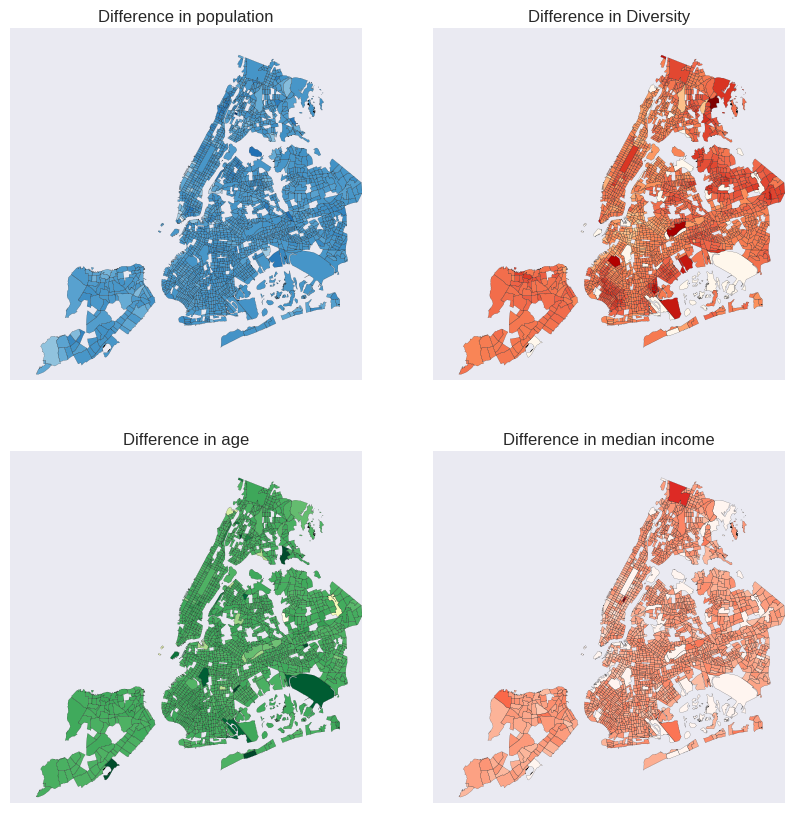

In [1783]:
fig = plt.figure(figsize = (10,10))
ax1 =fig.add_subplot(221)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
data_m_geo.plot(column='df_population',colormap='Blues',alpha=1,linewidth=0.1,ax=ax1)
plt.title("Difference in population",fontsize =12)

ax2 = fig.add_subplot(222)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
data_m_geo.plot(column='df_diversity',colormap='OrRd',alpha=1,linewidth=0.1,ax=ax2)
plt.title("Difference in Diversity",fontsize =12)

ax3 =fig.add_subplot(223)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
data_m_geo.plot(column='df_age',colormap='YlGn',alpha=1,linewidth=0.1,ax=ax3)
plt.title("Difference in age",fontsize =12)

ax4 = fig.add_subplot(224)
ax4.get_xaxis().set_visible(False)
ax4.get_yaxis().set_visible(False)
data_m_geo.plot(column='df_income',colormap='Reds',alpha=1,linewidth=0.1,ax=ax4)
plt.title("Difference in median income",fontsize =12)

plt.show()

#### Difference of features on map.

## (8) Cluster the census tracts on these four features

In [2413]:
data0_geo.head()

,boro_code,boro_ct_20,boro_name,cartodb_id,cdeligibil,ct_2010,ctlabel,geometry,ntacode,ntaname,puma,shape_area,shape_leng,allcodes,geo_id,age,diversity,income,population,zip
0,3,3027500,Brooklyn,1261,I,027500,275,POLYGON ((-73.93500821720123 40.68276376800321...,BK35,Stuyvesant Heights,4003,1743574.56294,5390.78775209,"(Brooklyn, 027500)",1400000US36047027500,33.9,1.5,30241.0,4171,11233
1,2,2009200,Bronx,1294,E,009200,92,POLYGON ((-73.84727881647562 40.82931474518224...,BX59,Westchester-Unionport,3709,3278193.62083,9143.90356952,"(Bronx, 009200)",1400000US36005009200,31.7,30.1,36589.0,4877,10462
2,4,4099100,Queens,1306,I,099100,991,POLYGON ((-73.79179280404088 40.78935161609342...,QN49,Whitestone,4103,11557974.9909,17092.0365078,"(Queens, 099100)",1400000US36081099100,47.1,87.7,62341.0,6659,11357
3,4,4000100,Queens,1407,I,000100,1,POLYGON ((-73.94911295133423 40.75452361982126...,QN31,Hunters Point-Sunnyside-West Maspeth,4109,12286326.8522,40345.5358859,"(Queens, 000100)",1400000US36081000100,41.3,55.4,85898.0,1370,11101
4,3,3024100,Brooklyn,1425,E,024100,241,POLYGON ((-73.95146465503193 40.68986334179581...,BK75,Bedford,4003,1939949.84007,5837.00532323,"(Brooklyn, 024100)",1400000US36047024100,36.2,10.4,10500.0,1564,11205


In [2420]:
data0_geo = data0_geo.dropna()

In [2421]:
centra0 = np.array(data0_geo.iloc[:,15:19])
ids = np.array(data0_geo['geo_id'])

In [2422]:
nc = 4

km = KMeans(n_clusters=nc, random_state=444)


km.fit(centra0)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=4, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=444, tol=0.0001,
    verbose=0)

In [2423]:
clustert0 = gp.GeoDataFrame()
clustert0['geo_id'] = ids
clustert0['cluster'] = km.labels_

In [2424]:
len(clustert0)

1890

In [2360]:
data10_geo = data10_geo.dropna()

In [2375]:
centra10 = data10_geo.iloc[:,16:20]
centra10.head()

,population,diversity,age,income
0,6250,15.5,32.7,2294.0
1,4180,9.1,35.6,1538.0
2,5017,29.5,33.3,1598.0
3,6507,85.5,51.1,2945.0
4,4949,63.5,32.4,1652.0


In [2376]:
centra10['diversity'] = centra10['diversity'].apply(pd.to_numeric, errors='coerce')

In [2377]:
centra10['population'] = centra10['population'].apply(pd.to_numeric, errors='coerce')

In [2378]:
centra10.head()

,population,diversity,age,income
0,6250,15.5,32.7,2294.0
1,4180,9.1,35.6,1538.0
2,5017,29.5,33.3,1598.0
3,6507,85.5,51.1,2945.0
4,4949,63.5,32.4,1652.0


In [2379]:
centra10 = np.array(centra10)
ids = np.array(data10_geo['geo_id'])

In [2385]:
centra10 = np.nan_to_num(centra10)

In [2388]:
center0 = km.cluster_centers_

In [2389]:
nc = 4

km = KMeans(n_clusters=nc, random_state=444, init = center0)


km.fit(centra10)

KMeans(copy_x=True,
    init=array([[  4.60722e+01,   8.95167e+01,   1.30970e+05,   3.36244e+03],
       [  3.11881e+01,   2.97116e+01,   2.41389e+04,   4.15730e+03],
       [  3.76328e+01,   6.54888e+01,   6.59944e+04,   3.76002e+03],
       [  3.54444e+01,   4.86263e+01,   4.30438e+04,   3.36502e+03]]),
    max_iter=300, n_clusters=4, n_init=10, n_jobs=1,
    precompute_distances='auto', random_state=444, tol=0.0001, verbose=0)

In [2390]:
clustert10 = gp.GeoDataFrame()
clustert10['geo_id'] = ids
clustert10['cluster'] = km.labels_

In [2391]:
clustert0.head()

,geo_id,cluster
0,1400000US36047027500,1
1,1400000US36005009200,3
2,1400000US36081099100,2
3,1400000US36081000100,2
4,1400000US36047024100,1


In [2428]:
clustert0_geo = pd.merge(ct_shape, clustert0, on = 'geo_id', how = 'inner')

In [2429]:
clustert0_geo.head(2)

,boro_code,boro_ct_20,boro_name,cartodb_id,cdeligibil,ct_2010,ctlabel,geometry,ntacode,ntaname,puma,shape_area,shape_leng,allcodes,geo_id,cluster
0,3,3027500,Brooklyn,1261,I,027500,275,POLYGON ((-73.93500821720123 40.68276376800321...,BK35,Stuyvesant Heights,4003,1743574.56294,5390.78775209,"(Brooklyn, 027500)",1400000US36047027500,1
1,2,2009200,Bronx,1294,E,009200,92,POLYGON ((-73.84727881647562 40.82931474518224...,BX59,Westchester-Unionport,3709,3278193.62083,9143.90356952,"(Bronx, 009200)",1400000US36005009200,3


In [2392]:
clustert10.head(3)

,geo_id,cluster
0,1400000US36047050804,2
1,1400000US36047027500,3
2,1400000US36005009200,3


In [2405]:
clustert10_geo = pd.merge(ct_shape, clustert10, on = 'geo_id', how = 'inner')

In [2406]:
clustert10_geo.head(2)

,boro_code,boro_ct_20,boro_name,cartodb_id,cdeligibil,ct_2010,ctlabel,geometry,ntacode,ntaname,puma,shape_area,shape_leng,allcodes,geo_id,cluster
0,3,3050804,Brooklyn,998,E,050804,508.04,POLYGON ((-73.96140739646273 40.65216985809441...,BK42,Flatbush,4015,1110945.63082,4305.94762341,"(Brooklyn, 050804)",1400000US36047050804,2
1,3,3027500,Brooklyn,1261,I,027500,275,POLYGON ((-73.93500821720123 40.68276376800321...,BK35,Stuyvesant Heights,4003,1743574.56294,5390.78775209,"(Brooklyn, 027500)",1400000US36047027500,3


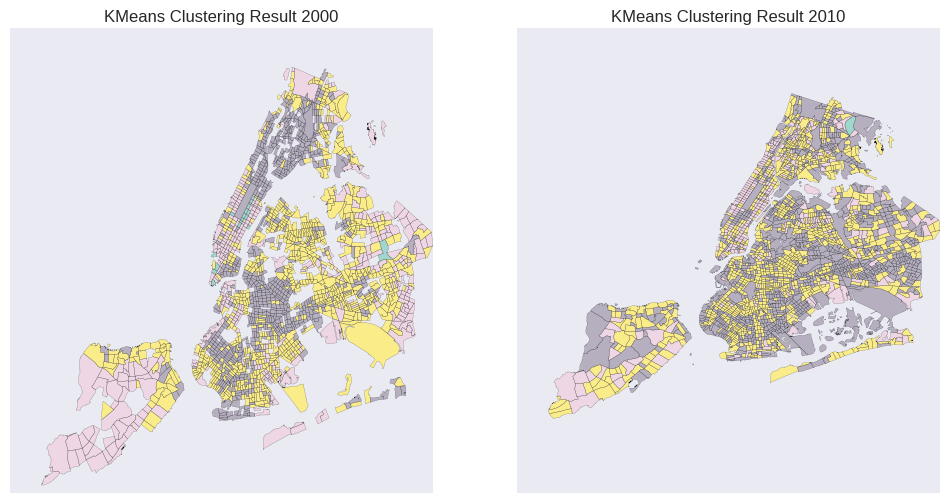

In [2433]:
fig = plt.figure(figsize = (12,6))

ax1 =fig.add_subplot(121)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
clustert0_geo.plot(column='cluster', colormap='Set3',alpha=0.8,linewidth=0.1, ax=ax1)
plt.title('KMeans Clustering Result 2000')

ax2 =fig.add_subplot(122)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
clustert10_geo.plot(column='cluster', colormap='Set3',alpha=0.8,linewidth=0.1, ax=ax2)
plt.title('KMeans Clustering Result 2010')

plt.show()

In [2393]:
cluster_ct = pd.merge(clustert0, clustert10, on = 'geo_id', how = 'inner')

In [2394]:
cluster_ct.head()

,geo_id,cluster_x,cluster_y
0,1400000US36047027500,1,3
1,1400000US36005009200,3,3
2,1400000US36081099100,2,2
3,1400000US36081000100,2,3
4,1400000US36047024100,1,1


## (9) Identify the census tracts that have changed cluster assignment and show a choropleth of the clusters in 2010, 2000 and a choropleth of the cluster changes. 

In [2395]:
cluster_dif = cluster_ct[cluster_ct['cluster_x'] != cluster_ct['cluster_y']]

In [2431]:
cluster_dif.head()

,geo_id,cluster_x,cluster_y
0,1400000US36047027500,1,3
3,1400000US36081000100,2,3
5,1400000US36047001800,2,1
6,1400000US36047070600,2,1
7,1400000US36085029102,2,1


In [2434]:
cluster_dif_geo = pd.merge(ct_shape, cluster_dif, on = 'geo_id', how = 'inner')

In [2436]:
cluster_dif_geo.head(2)

,boro_code,boro_ct_20,boro_name,cartodb_id,cdeligibil,ct_2010,ctlabel,geometry,ntacode,ntaname,puma,shape_area,shape_leng,allcodes,geo_id,cluster_x,cluster_y
0,3,3027500,Brooklyn,1261,I,027500,275,POLYGON ((-73.93500821720123 40.68276376800321...,BK35,Stuyvesant Heights,4003,1743574.56294,5390.78775209,"(Brooklyn, 027500)",1400000US36047027500,1,3
1,4,4000100,Queens,1407,I,000100,1,POLYGON ((-73.94911295133423 40.75452361982126...,QN31,Hunters Point-Sunnyside-West Maspeth,4109,12286326.8522,40345.5358859,"(Queens, 000100)",1400000US36081000100,2,3


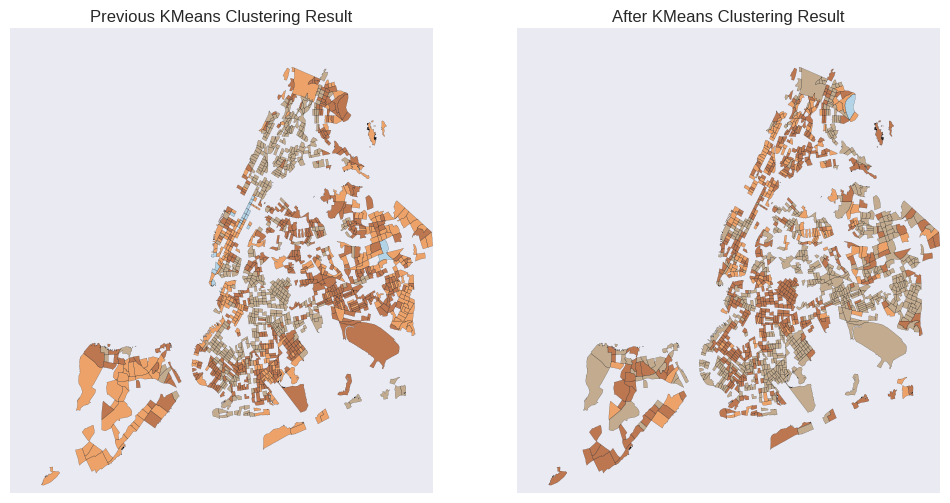

In [2439]:
fig = plt.figure(figsize = (12,6))

ax1 =fig.add_subplot(121)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
cluster_dif_geo.plot(column='cluster_x', colormap='Paired',alpha=0.8,linewidth=0.1, ax=ax1)
plt.title('Previous KMeans Clustering Result')

ax2 =fig.add_subplot(122)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
cluster_dif_geo.plot(column='cluster_y', colormap='Paired',alpha=0.8,linewidth=0.1, ax=ax2)
plt.title('After KMeans Clustering Result')

plt.show()

#### census tract that changes clusters on map

In [1194]:
nyzip.crs

{'init': u'epsg:4326'}

In [1301]:
nyzip.crs = from_epsg(2263)

In [1350]:
nyzip.crs

{'init': u'epsg:4326'}

In [1357]:
ct_latlon.crs

{'init': 'epsg:4326', 'no_defs': True}

In [1199]:
ct_shape.geometry.centroid.head()

0    POINT (-73.96357170886373 40.65283697070946)
1    POINT (-73.93817848656671 40.68389702206226)
2    POINT (-73.85210980914427 40.83235749781331)
3      POINT (-73.80002155529998 40.790302402768)
4     POINT (-73.95065259363994 40.7432126398649)
dtype: object

In [1373]:
type(data0_geo)

geopandas.geodataframe.GeoDataFrame

In [1200]:
nyzip.geometry.centroid.head()

0    POINT (-73.88357286802307 40.75166307169953)
1    POINT (-73.71160619542474 40.74537094501076)
2       POINT (-73.70344982649 40.74873122436191)
3    POINT (-73.72400273065516 40.73653495923434)
4     POINT (-73.7946136039439 40.73990335985973)
dtype: object

In [1298]:
nyzip.head()

,geometry,zip
0,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,POLYGON ((-73.81088634744755 40.72717187575918...,11365


In [1233]:
type(nyzip['latlon'][0])

shapely.geometry.point.Point

In [1228]:
nyzip.latlon.head()

0    POINT (-73.88357286802307 40.75166307169953)
1    POINT (-73.71160619542474 40.74537094501076)
2       POINT (-73.70344982649 40.74873122436191)
3    POINT (-73.72400273065516 40.73653495923434)
4     POINT (-73.7946136039439 40.73990335985973)
Name: latlon, dtype: object

In [1380]:
type(data0_geo)

geopandas.geodataframe.GeoDataFrame

In [1382]:
data0_geo.crs = from_epsg(4326)

In [1383]:
data0_geo.crs

{'init': 'epsg:4326', 'no_defs': True}

In [1393]:
nyzip[nyzip.geometry.intersects(data0_geo.iloc[7].geometry.centroid)].zip.values[0]

u'11234'

In [1302]:
nyzip.crs

{'init': 'epsg:2263', 'no_defs': True}

In [1478]:
if nyzip[nyzip.geometry.intersects(data0_geo.iloc[131].geometry.centroid)].empty == True

True

In [1439]:
nyzip[nyzip.geometry.intersects(data0_geo.iloc[225].geometry.centroid)].zip

Series([], Name: zip, dtype: object)

In [1463]:
nyzip[nyzip.geometry.intersects(data0_geo.iloc[253].geometry.centroid)].zip

104    11377
Name: zip, dtype: object

## (10) Aggregate the census four features at the zipcode level and merge the zipcode dataframe

In [1488]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(data0_geo)):
    if nyzip[nyzip.geometry.intersects(data0_geo.iloc[i].geometry.centroid)].empty == True:
        a.append('NaN')
    else:
        a.append(nyzip[nyzip.geometry.intersects(data0_geo.iloc[i].geometry.centroid)].zip.values[0])
data0_geo['zip'] = a

In [1489]:
data0_geo.head()

,boro_code,boro_ct_20,boro_name,cartodb_id,cdeligibil,ct_2010,ctlabel,geometry,ntacode,ntaname,puma,shape_area,shape_leng,allcodes,geo_id,age,diversity,income,population,zip
0,3,3027500,Brooklyn,1261,I,027500,275,POLYGON ((-73.93500821720123 40.68276376800321...,BK35,Stuyvesant Heights,4003,1743574.56294,5390.78775209,"(Brooklyn, 027500)",1400000US36047027500,33.9,1.5,30241.0,4171,11233
1,2,2009200,Bronx,1294,E,009200,92,POLYGON ((-73.84727881647562 40.82931474518224...,BX59,Westchester-Unionport,3709,3278193.62083,9143.90356952,"(Bronx, 009200)",1400000US36005009200,31.7,30.1,36589.0,4877,10462
2,4,4099100,Queens,1306,I,099100,991,POLYGON ((-73.79179280404088 40.78935161609342...,QN49,Whitestone,4103,11557974.9909,17092.0365078,"(Queens, 099100)",1400000US36081099100,47.1,87.7,62341.0,6659,11357
3,4,4000100,Queens,1407,I,000100,1,POLYGON ((-73.94911295133423 40.75452361982126...,QN31,Hunters Point-Sunnyside-West Maspeth,4109,12286326.8522,40345.5358859,"(Queens, 000100)",1400000US36081000100,41.3,55.4,85898.0,1370,11101
4,3,3024100,Brooklyn,1425,E,024100,241,POLYGON ((-73.95146465503193 40.68986334179581...,BK75,Bedford,4003,1939949.84007,5837.00532323,"(Brooklyn, 024100)",1400000US36047024100,36.2,10.4,10500.0,1564,11205


In [1493]:
len(data0_geo)

1929

In [1526]:
data0_zip_age = data0_geo[['zip', 'age']]

In [1524]:
data0_zip_age.head()

,zip,age
0,11233,33.9
1,10462,31.7
2,11357,47.1
3,11101,41.3
4,11205,36.2


In [1519]:
data0_zip_agem = pd.DataFrame(data_zip_age.groupby('zip', as_index= False)['age'].mean())

In [1520]:
data0_zip_agem.head()

,zip,age
0,00083,38.500000
1,10001,37.000000
2,10002,37.857143
3,10003,33.970000
4,10004,31.100000


In [1531]:
data0_zip_income = data0_geo[['zip', 'income']]

data0_zip_incomem = pd.DataFrame(data0_zip_income.groupby('zip', as_index= False)['income'].mean())
data0_zip_incomem.head()

,zip,income
0,00083,18750.000000
1,10001,53814.666667
2,10002,25544.357143
3,10003,67424.400000
4,10004,93353.500000


In [1533]:
data0_zip_div = data0_geo[['zip', 'diversity']]

data0_zip_divm = pd.DataFrame(data0_zip_div.groupby('zip', as_index= False)['diversity'].mean())
data0_zip_divm.head()

,zip,diversity
0,00083,44.400000
1,10001,63.566667
2,10002,35.821429
3,10003,77.980000
4,10004,80.100000


In [1633]:
data0_zip_pop = data0_geo[['zip', 'population']]

data0_zip_popm = pd.DataFrame(data0_zip_pop.groupby('zip', as_index= False)['population'].mean())
data0_zip_popm.head()

,zip,population
0,00083,18.000000
1,10001,2149.333333
2,10002,6061.142857
3,10003,5294.300000
4,10004,481.666667


In [1543]:
data0_zip1 = pd.merge(data0_zip_agem, data0_zip_incomem, on = 'zip', how = 'inner')

data0_zip2 = pd.merge(data0_zip_divm, data0_zip_popm, on = 'zip', how = 'inner')

data0_zip = pd.merge(data0_zip1, data0_zip2, on = 'zip', how = 'inner')

In [1544]:
data0_zip.head()

,zip,age,income,diversity,population
0,00083,38.500000,18750.000000,44.400000,18.000000
1,10001,37.000000,53814.666667,63.566667,2149.333333
2,10002,37.857143,25544.357143,35.821429,6061.142857
3,10003,33.970000,67424.400000,77.980000,5294.300000
4,10004,31.100000,93353.500000,80.100000,481.666667


In [1669]:
n=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(data10_geo)):
    if nyzip[nyzip.geometry.intersects(data10_geo.iloc[i].geometry.centroid)].empty == True:
        n.append('NaN')
    else:
        n.append(nyzip[nyzip.geometry.intersects(data10_geo.iloc[i].geometry.centroid)].zip.values[0])
data10_geo['zip'] = n

In [1670]:
data10_geo.head()

,boro_code,boro_ct_20,boro_name,cartodb_id,cdeligibil,ct_2010,ctlabel,geometry,ntacode,ntaname,puma,shape_area,shape_leng,allcodes,geo_id,geo_id2,population,diversity,age,income,zip
0,3,3050804,Brooklyn,998,E,050804,508.04,POLYGON ((-73.96140739646273 40.65216985809441...,BK42,Flatbush,4015,1110945.63082,4305.94762341,"(Brooklyn, 050804)",1400000US36047050804,36047050804,6250,15.5,32.7,2294.0,11226
1,3,3027500,Brooklyn,1261,I,027500,275,POLYGON ((-73.93500821720123 40.68276376800321...,BK35,Stuyvesant Heights,4003,1743574.56294,5390.78775209,"(Brooklyn, 027500)",1400000US36047027500,36047027500,4180,9.1,35.6,1538.0,11233
2,2,2009200,Bronx,1294,E,009200,92,POLYGON ((-73.84727881647562 40.82931474518224...,BX59,Westchester-Unionport,3709,3278193.62083,9143.90356952,"(Bronx, 009200)",1400000US36005009200,36005009200,5017,29.5,33.3,1598.0,10462
3,4,4099100,Queens,1306,I,099100,991,POLYGON ((-73.79179280404088 40.78935161609342...,QN49,Whitestone,4103,11557974.9909,17092.0365078,"(Queens, 099100)",1400000US36081099100,36081099100,6507,85.5,51.1,2945.0,11357
4,4,4000100,Queens,1407,I,000100,1,POLYGON ((-73.94911295133423 40.75452361982126...,QN31,Hunters Point-Sunnyside-West Maspeth,4109,12286326.8522,40345.5358859,"(Queens, 000100)",1400000US36081000100,36081000100,4949,63.5,32.4,1652.0,11101


In [1671]:
data10_geo['age'] = data10_geo['age'].astype(float)

In [1672]:
data10_geo['income'] = data10_geo['income'].astype(float)

In [1673]:
data10_zip_age = data10_geo[['zip', 'age']]

data10_zip_agem = pd.DataFrame(data10_zip_age.groupby('zip', as_index= False)['age'].mean())

In [1674]:
data10_zip_age.head()

,zip,age
0,11226,32.7
1,11233,35.6
2,10462,33.3
3,11357,51.1
4,11101,32.4


In [1675]:
data10_zip_income = data10_geo[['zip', 'income']]

data10_zip_incomem = pd.DataFrame(data10_zip_income.groupby('zip', as_index= False)['income'].mean())

In [1676]:
data10_zip_incomem.head()

,zip,income
0,00083,14.000000
1,10001,1203.333333
2,10002,2334.642857
3,10003,2652.500000
4,10004,77.000000


In [1677]:
data10_zip_div = data10_geo[['zip', 'diversity']]

In [1679]:
data10_zip_div['diversity'] = data10_zip_div['diversity'].apply(pd.to_numeric, errors='coerce')

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [1680]:
data10_zip_div.dtypes

zip           object
diversity    float64
dtype: object

In [ ]:
data10_zip_div['zip'] = data10_zip_div['zip'].astype(int)

In [1681]:
data10_zip_divm = pd.DataFrame(data10_zip_div.groupby('zip', as_index= False)['diversity'].mean())
data10_zip_divm.head()

,zip,diversity
0,00083,24.000000
1,10001,63.550000
2,10002,40.385714
3,10003,76.630000
4,10004,57.750000


In [1687]:
data10_zip_pop = data10_geo[['zip', 'population']]

In [1688]:
data10_zip_pop['population'] = data10_zip_pop['population'].apply(pd.to_numeric, errors='coerce')

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [1689]:
data10_zip_pop.dtypes

zip           object
population     int64
dtype: object

In [1690]:
data10_zip_popm = pd.DataFrame(data10_zip_pop.groupby('zip', as_index= False)['population'].mean())
data10_zip_popm.head()

,zip,population
0,00083,25.000000
1,10001,2610.000000
2,10002,5758.357143
3,10003,5528.200000
4,10004,247.333333


In [1691]:
data10_zip1 = pd.merge(data10_zip_agem, data10_zip_incomem, on = 'zip', how = 'inner')

data10_zip2 = pd.merge(data10_zip_divm, data10_zip_popm, on = 'zip', how = 'inner')

data10_zip = pd.merge(data10_zip1, data10_zip2, on = 'zip', how = 'inner')

In [1659]:
data00_zip = pd.merge(zp2000, data0_zip, on = 'zip', how = 'inner')

In [1692]:
data10_zip.head()

,zip,age,income,diversity,population
0,00083,43.200000,14.000000,24.000000,25.000000
1,10001,34.633333,1203.333333,63.550000,2610.000000
2,10002,39.821429,2334.642857,40.385714,5758.357143
3,10003,32.670000,2652.500000,76.630000,5528.200000
4,10004,25.966667,77.000000,57.750000,247.333333


In [1657]:
type(zp2000['zip'][0])

numpy.int64

In [1658]:
zp2000['zip'] = zp2000['zip'].astype(unicode)

### zipcode merged dataframe for 2000

In [1660]:
data00_zip.head()

,zip,00,age,income,diversity,population
0,10001,7317,37.000000,53814.666667,63.566667,2149.333333
1,10002,2277,37.857143,25544.357143,35.821429,6061.142857
2,10003,3683,33.970000,67424.400000,77.980000,5294.300000
3,10004,1294,31.100000,93353.500000,80.100000,481.666667
4,10005,1287,28.400000,81071.000000,67.500000,907.000000


In [1661]:
zp2010['zip'] = zp2010['zip'].astype(unicode)

In [1665]:
type(zp2010['zip'][0])

unicode

In [1666]:
type(data10_zip['zip'][0])

unicode

In [1693]:
data010_zip = pd.merge(zp2010, data10_zip, on = 'zip', how = 'inner')

### zipcode merged dataframe for 2010

In [1694]:
data010_zip.head()

,zip,10,age,income,diversity,population
0,10001,7241,34.633333,1203.333333,63.550000,2610.000000
1,10002,2872,39.821429,2334.642857,40.385714,5758.357143
2,10003,4113,32.670000,2652.500000,76.630000,5528.200000
3,10004,1398,25.966667,77.000000,57.750000,247.333333
4,10005,1266,29.100000,2907.000000,70.200000,8109.000000


## (11) Repeat steps 7,8,9 at the zipcode level

In [1695]:
nyzip.head(3)

,geometry,zip
0,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,POLYGON ((-73.70098278625547 40.73889569923034...,11040


In [1698]:
data0_zipgeo = pd.merge(nyzip, data00_zip, on = 'zip', how = 'inner')

In [1699]:
data0_zipgeo.head(3)

,geometry,zip,00,age,income,diversity,population
0,POLYGON ((-73.86942457284175 40.74915687096787...,11372,1409,35.500000,39694.300000,51.0,7118.600000
1,POLYGON ((-73.71068374074007 40.75004039450917...,11004,189,41.533333,58212.333333,60.8,5457.666667
2,POLYGON ((-73.72270447144122 40.75373371438336...,11426,213,38.700000,50010.600000,57.3,4093.200000


In [1700]:
data10_zipgeo = pd.merge(nyzip, data010_zip, on = 'zip', how = 'inner')

In [1701]:
data10_zipgeo.head(3)

,geometry,zip,10,age,income,diversity,population
0,POLYGON ((-73.86942457284175 40.74915687096787...,11372,1629,38.100000,2419.1,46.95,6690.5
1,POLYGON ((-73.71068374074007 40.75004039450917...,11004,229,45.966667,2152.0,48.40,5607.0
2,POLYGON ((-73.72270447144122 40.75373371438336...,11426,248,39.360000,1348.2,37.82,4299.2


In [ ]:
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)

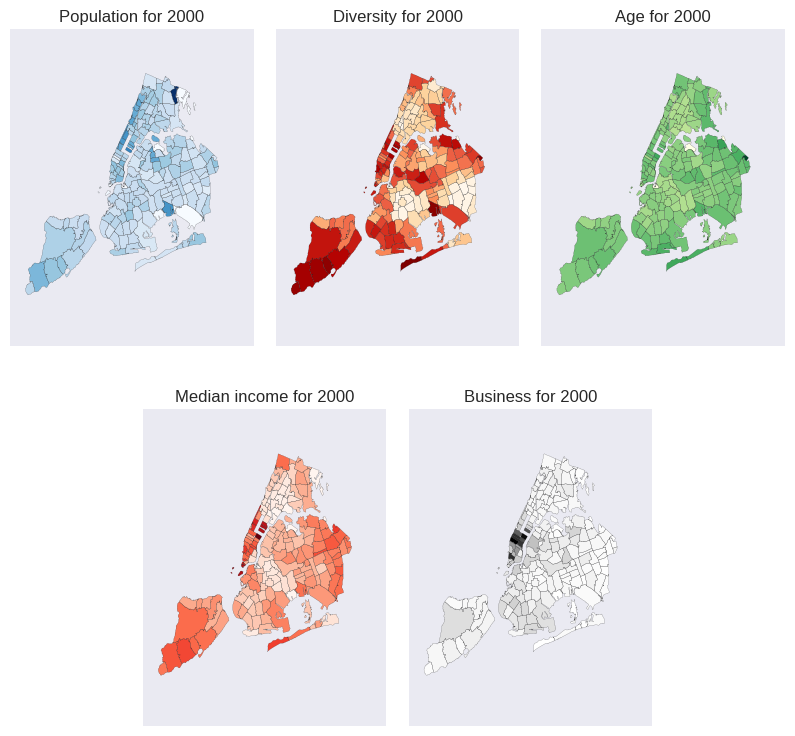

In [1709]:
fig = plt.figure(figsize = (10,9))
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
data0_zipgeo.plot(column='population',colormap='Blues',alpha=1,linewidth=0.1,ax=ax1)
plt.title("Population for 2000",fontsize =12)

ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
data0_zipgeo.plot(column='diversity',colormap='OrRd',alpha=1,linewidth=0.1,ax=ax2)
plt.title("Diversity for 2000",fontsize =12)

ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
data0_zipgeo.plot(column='age',colormap='YlGn',alpha=1,linewidth=0.1,ax=ax3)
plt.title("Age for 2000",fontsize =12)

ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax4.get_xaxis().set_visible(False)
ax4.get_yaxis().set_visible(False)
data0_zipgeo.plot(column='income',colormap='Reds',alpha=1,linewidth=0.1,ax=ax4)
plt.title("Median income for 2000",fontsize =12)

ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
ax5.get_xaxis().set_visible(False)
ax5.get_yaxis().set_visible(False)
data0_zipgeo.plot(column='00',colormap='Greys',alpha=1,linewidth=0.1,ax=ax5)
plt.title("Business for 2000",fontsize =12)

plt.show()

#### Graphs for features on map for 2000. The new feature business number share same reginal character with income feature. Which very much make sense.

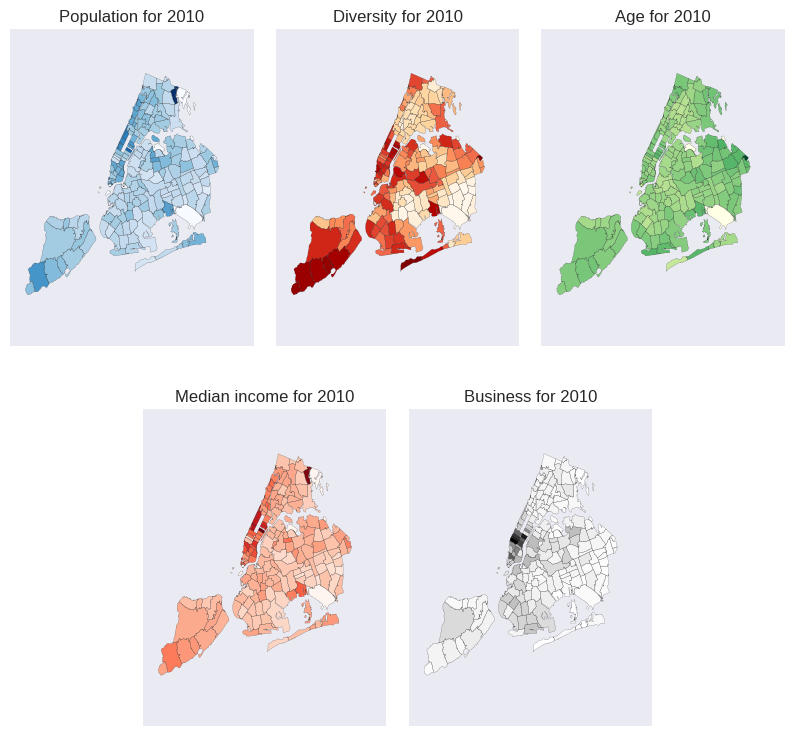

In [1710]:
fig = plt.figure(figsize = (10,9))
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
data10_zipgeo.plot(column='population',colormap='Blues',alpha=1,linewidth=0.1,ax=ax1)
plt.title("Population for 2010",fontsize =12)

ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
data10_zipgeo.plot(column='diversity',colormap='OrRd',alpha=1,linewidth=0.1,ax=ax2)
plt.title("Diversity for 2010",fontsize =12)

ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
data10_zipgeo.plot(column='age',colormap='YlGn',alpha=1,linewidth=0.1,ax=ax3)
plt.title("Age for 2010",fontsize =12)

ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax4.get_xaxis().set_visible(False)
ax4.get_yaxis().set_visible(False)
data10_zipgeo.plot(column='income',colormap='Reds',alpha=1,linewidth=0.1,ax=ax4)
plt.title("Median income for 2010",fontsize =12)

ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
ax5.get_xaxis().set_visible(False)
ax5.get_yaxis().set_visible(False)
data10_zipgeo.plot(column='10',colormap='Greys',alpha=1,linewidth=0.1,ax=ax5)
plt.title("Business for 2010",fontsize =12)

plt.show()

#### Graphs for features on map for 2010. The new feature business number share same reginal character with income feature as in 2000.

### Cluster at zipcode level on 5 features

In [1806]:
data00_zip.head(3)

,zip,00,age,income,diversity,population
0,10001,7317,37.000000,53814.666667,63.566667,2149.333333
1,10002,2277,37.857143,25544.357143,35.821429,6061.142857
2,10003,3683,33.970000,67424.400000,77.980000,5294.300000


In [1807]:
data00_zip = data00_zip.dropna()

In [1853]:
val0 = np.array(data00_zip.iloc[:,1:6])
zips = np.array(data00_zip['zip'])

### K-means Cluster for 2000

In [2442]:
nc = 4

km = KMeans(n_clusters=nc, random_state=444)


km.fit(val0)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=4, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=444, tol=0.0001,
    verbose=0)

In [1855]:
for j in range(4):
    print ("zipcodes in cluster", j, )
    print (zips[km.labels_==j])
    print ("\n\n\n\n")
    
cluster00 = gp.GeoDataFrame()
cluster00['zip'] = zips
cluster00['cluster'] = km.labels_

('zipcodes in cluster', 0)
[u'10018' u'10025' u'10036' u'10038' u'10069' u'10301' u'10302' u'10303'
 u'10304' u'10305' u'10310' u'10461' u'10462' u'10463' u'10465' u'10466'
 u'10469' u'10470' u'10475' u'11101' u'11102' u'11103' u'11104' u'11105'
 u'11106' u'11203' u'11204' u'11209' u'11210' u'11214' u'11217' u'11222'
 u'11223' u'11228' u'11229' u'11230' u'11231' u'11232' u'11235' u'11236'
 u'11238' u'11354' u'11355' u'11356' u'11367' u'11368' u'11369' u'11370'
 u'11372' u'11373' u'11374' u'11375' u'11377' u'11378' u'11385' u'11412'
 u'11415' u'11416' u'11417' u'11418' u'11419' u'11420' u'11421' u'11426'
 u'11430' u'11432' u'11434' u'11435' u'11436' u'11692' u'11693']





('zipcodes in cluster', 1)
[u'10002' u'10009' u'10026' u'10027' u'10029' u'10030' u'10031' u'10032'
 u'10033' u'10034' u'10035' u'10037' u'10039' u'10040' u'10451' u'10452'
 u'10453' u'10454' u'10455' u'10456' u'10457' u'10458' u'10459' u'10460'
 u'10467' u'10468' u'10472' u'10473' u'10474' u'11205' u'11206' u'11207'


In [2443]:
center = km.cluster_centers_

In [1857]:
cluster00.head()

,zip,cluster
0,10001,3
1,10002,1
2,10003,3
3,10004,2
4,10005,2


In [1813]:
type(cluster00['zip'][0])

unicode

In [1858]:
data010_zip = data010_zip.dropna()

In [1859]:
val1 = np.array(data010_zip.iloc[:,1:6])
zips = np.array(data010_zip['zip'])

### K-means Cluster for 2010

In [2444]:

nc = 4

km = KMeans(n_clusters=nc, random_state=444, init = center)


km.fit(val1)

KMeans(copy_x=True,
    init=array([[  9.94958e+02,   3.50160e+01,   4.18792e+04,   5.00623e+01,
          3.58208e+03],
       [  6.59812e+02,   3.07753e+01,   2.46625e+04,   2.38940e+01,
          4.42459e+03],
       [  2.59460e+03,   3.68242e+01,   8.72868e+04,   8.35929e+01,
          4.99381e+03],
       [  1.47849e+03,   3.89692e+01,   6.01263e+04,   6.53023e+01,
          3.75605e+03]]),
    max_iter=300, n_clusters=4, n_init=10, n_jobs=1,
    precompute_distances='auto', random_state=444, tol=0.0001, verbose=0)

In [2445]:
for j in range(4):
    print ("zipcodes in cluster", j, )
    print (zips[km.labels_==j])
    print ("\n\n\n\n")
    
cluster10 = gp.GeoDataFrame()
cluster10['zip'] = zips
cluster10['cluster'] = km.labels_

('zipcodes in cluster', 0)
[u'10004' u'10301' u'10310' u'10457' u'10461' u'10464' u'10465' u'10466'
 u'10469' u'10470' u'10471' u'11005' u'11101' u'11102' u'11103' u'11105'
 u'11106' u'11201' u'11203' u'11204' u'11205' u'11206' u'11207' u'11208'
 u'11209' u'11210' u'11214' u'11215' u'11216' u'11217' u'11221' u'11222'
 u'11223' u'11228' u'11229' u'11230' u'11231' u'11232' u'11233' u'11234'
 u'11235' u'11236' u'11251' u'11358' u'11361' u'11363' u'11364' u'11366'
 u'11369' u'11375' u'11378' u'11379' u'11385' u'11411' u'11412' u'11413'
 u'11415' u'11416' u'11417' u'11418' u'11419' u'11420' u'11421' u'11423'
 u'11427' u'11428' u'11429' u'11432' u'11433' u'11434' u'11435' u'11436'
 u'11694' u'11697']





('zipcodes in cluster', 1)
[u'10002' u'10005' u'10009' u'10010' u'10011' u'10021' u'10023' u'10024'
 u'10025' u'10028' u'10032' u'10033' u'10040' u'10069' u'10128' u'10282'
 u'10309' u'10475' u'11372' u'11414']





('zipcodes in cluster', 2)
[u'10001' u'10003' u'10013' u'10016' u'10017' u'

In [2446]:
cluster10.head()

,zip,cluster
0,10001,2
1,10002,1
2,10003,2
3,10004,0
4,10005,1


In [1863]:
type(nyzip['zip'][0])

unicode

In [1864]:
nyzip.head()

,geometry,zip
0,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,POLYGON ((-73.81088634744755 40.72717187575918...,11365


In [1865]:
cluster00_geo = pd.merge(nyzip, cluster00, on = 'zip', how = 'inner')

In [1866]:
cluster00_geo = cluster00_geo.sort(['cluster'], ascending=[True])

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [1867]:
cluster00_geo.head()

,geometry,zip,cluster
0,POLYGON ((-73.86942457284175 40.74915687096787...,11372,0
125,POLYGON ((-73.75047056218064 40.70563994798906...,11412,0
122,POLYGON ((-73.99922642801454 40.70787485413706...,10038,0
121,"POLYGON ((-73.92409190873964 40.7139631501864,...",11385,0
114,"POLYGON ((-73.92420859750851 40.7355195121288,...",11378,0


In [2447]:
cluster10_geo = pd.merge(nyzip, cluster10, on = 'zip', how = 'inner')

In [2448]:
cluster10_geo = cluster10_geo.sort(['cluster'], ascending=[True])

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [1870]:
type(cluster00)

geopandas.geodataframe.GeoDataFrame

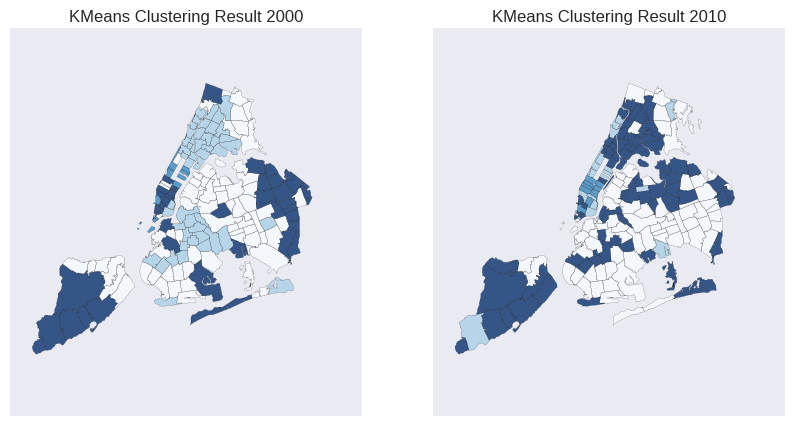

In [2449]:
fig = plt.figure(figsize = (10,5))

ax1 =fig.add_subplot(121)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
cluster00_geo.plot(column='cluster', colormap='Blues',alpha=0.8,linewidth=0.1, ax=ax1)
plt.title('KMeans Clustering Result 2000')

ax2 =fig.add_subplot(122)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
cluster10_geo.plot(column='cluster', colormap='Blues',alpha=0.8,linewidth=0.1, ax=ax2)
plt.title('KMeans Clustering Result 2010')

plt.show()

#### Cluster result on zipcode for 2000 and 2010.

In [1874]:
zip_cluster = pd.merge(cluster00, cluster10, on = 'zip', how = 'inner')

In [1879]:
zip_all = pd.merge(data00_zip, data010_zip, on = 'zip', how ='inner')

In [1880]:
zip_all.head()

,zip,00,age_x,income_x,diversity_x,population_x,10,age_y,income_y,diversity_y,population_y
0,10001,7317,37.000000,53814.666667,63.566667,2149.333333,7241,34.633333,1203.333333,63.550000,2610.000000
1,10002,2277,37.857143,25544.357143,35.821429,6061.142857,2872,39.821429,2334.642857,40.385714,5758.357143
2,10003,3683,33.970000,67424.400000,77.980000,5294.300000,4113,32.670000,2652.500000,76.630000,5528.200000
3,10004,1294,31.100000,93353.500000,80.100000,481.666667,1398,25.966667,77.000000,57.750000,247.333333
4,10005,1287,28.400000,81071.000000,67.500000,907.000000,1266,29.100000,2907.000000,70.200000,8109.000000


In [2057]:
zip_fi = pd.merge(zip_all, zip_cluster, on = 'zip', how ='inner')

In [2058]:
zip_fi.rename(columns={'00': 'bu_x', '10': 'bu_y'}, inplace=True)

In [2059]:
zip_fi.head()

,zip,bu_x,age_x,income_x,diversity_x,population_x,bu_y,age_y,income_y,diversity_y,population_y,cluster_x,cluster_y
0,10001,7317,37.000000,53814.666667,63.566667,2149.333333,7241,34.633333,1203.333333,63.550000,2610.000000,3,2
1,10002,2277,37.857143,25544.357143,35.821429,6061.142857,2872,39.821429,2334.642857,40.385714,5758.357143,1,1
2,10003,3683,33.970000,67424.400000,77.980000,5294.300000,4113,32.670000,2652.500000,76.630000,5528.200000,3,2
3,10004,1294,31.100000,93353.500000,80.100000,481.666667,1398,25.966667,77.000000,57.750000,247.333333,2,0
4,10005,1287,28.400000,81071.000000,67.500000,907.000000,1266,29.100000,2907.000000,70.200000,8109.000000,2,1


In [2017]:
pop00c1 = np.sort(np.random.choice(zip_fi.age_x[zip_fi.cluster_x == 1], len(pop10c2), replace=False))

pop00c2 = np.sort(np.random.choice(zip_fi.age_x[zip_fi.cluster_x == 2], len(pop10c2), replace=False))

pop00c0 = np.sort(np.random.choice(zip_fi.age_x[zip_fi.cluster_x == 0], len(pop10c2), replace=False))

pop00c3 = np.sort(np.random.choice(zip_fi.age_x[zip_fi.cluster_x == 3], len(pop10c2), replace=False))

In [2018]:
len(pop10c2)

9

In [2019]:
pop10c0 = np.sort(np.random.choice(zip_fi.age_y[zip_fi.cluster_y == 0], len(pop10c2), replace=False))

pop10c1 = np.sort(np.random.choice(zip_fi.age_y[zip_fi.cluster_y == 1], len(pop10c2), replace=False))

pop10c2 = zip_fi.age_y[zip_fi.cluster_y == 2]

pop10c3 = np.sort(np.random.choice(zip_fi.age_y[zip_fi.cluster_y == 3], len(pop10c2), replace=False))

In [2020]:
print scipy.stats.pearsonr(pop00c1, pop10c1)

(0.77518036860164441, 0.014125764052414646)


In [2021]:
scipy.stats.pearsonr(pop00c2, pop10c2)

(0.49353078463256689, 0.17695987644637354)

## (12) Define a function that given a dataframe containing the relevant information and two cluster labels finds if the census tract changed cluster assignments from the first to the second label, and if so finds the individual features that are significantly different as measured by Pearson's correlation, plot those zip codes, and plot a histogram of the features that have significantly changed. Run your function for all label pairs.

In [2515]:
a = []
def check_label(dataframe, n, m):
    #for i in range(len(dataframe))
            a = np.array(dataframe['cluster_x'])[0]
            b = np.array(dataframe['cluster_y'])[0]
            if a == n and b == n:
                print 'The census track is in same cluster'
            elif a == n and b == m:
                pop00n = np.sort(np.random.choice(zip_fi.population_x[zip_fi.cluster_x == n], len(pop00c2), replace=False))
                pop00m = np.sort(np.random.choice(zip_fi.population_x[zip_fi.cluster_x == m], len(pop00c2), replace=False))
                pop10n = np.sort(np.random.choice(zip_fi.population_y[zip_fi.cluster_y == n], len(pop10c2), replace=False))
                pop10m = np.sort(np.random.choice(zip_fi.population_y[zip_fi.cluster_y == m], len(pop10c2), replace=False))
                div00n = np.sort(np.random.choice(zip_fi.diversity_x[zip_fi.cluster_x == n], len(pop00c2), replace=False))
                div00m = np.sort(np.random.choice(zip_fi.diversity_x[zip_fi.cluster_x == m], len(pop00c2), replace=False))
                div10n = np.sort(np.random.choice(zip_fi.diversity_y[zip_fi.cluster_y == n], len(pop10c2), replace=False))
                div10m = np.sort(np.random.choice(zip_fi.diversity_y[zip_fi.cluster_y == m], len(pop10c2), replace=False))
                inc00n = np.sort(np.random.choice(zip_fi.income_x[zip_fi.cluster_x == n], len(pop00c2), replace=False))
                inc00m = np.sort(np.random.choice(zip_fi.income_x[zip_fi.cluster_x == m], len(pop00c2), replace=False))
                inc10n = np.sort(np.random.choice(zip_fi.income_y[zip_fi.cluster_y == n], len(pop10c2), replace=False))
                inc10m = np.sort(np.random.choice(zip_fi.income_y[zip_fi.cluster_y == m], len(pop10c2), replace=False))
                age00n = np.sort(np.random.choice(zip_fi.age_x[zip_fi.cluster_x == n], len(pop00c2), replace=False))
                age00m = np.sort(np.random.choice(zip_fi.age_x[zip_fi.cluster_x == m], len(pop00c2), replace=False))
                age10n = np.sort(np.random.choice(zip_fi.age_y[zip_fi.cluster_y == n], len(pop10c2), replace=False))
                age10m = np.sort(np.random.choice(zip_fi.age_y[zip_fi.cluster_y == m], len(pop10c2), replace=False))
                bus00n = np.sort(np.random.choice(zip_fi.bu_x[zip_fi.cluster_x == n], len(pop00c2), replace=False))
                bus00m = np.sort(np.random.choice(zip_fi.bu_x[zip_fi.cluster_x == m], len(pop00c2), replace=False))
                bus10n = np.sort(np.random.choice(zip_fi.bu_y[zip_fi.cluster_y == n], len(pop10c2), replace=False))
                bus10m = np.sort(np.random.choice(zip_fi.bu_y[zip_fi.cluster_y == m], len(pop10c2), replace=False))
                #print "Pearson correlation for population of 2000 in cluster %s"%n + ", and 2010 in cluster %s:" %n
                popn =  scipy.stats.pearsonr(pop00n, pop10n)[0]
                popn
                #print "Pearson correlation for population of 2000 in cluster %s"%m + ", and 2010 in cluster %s:" %m
                popm = scipy.stats.pearsonr(pop00m, pop10m)[0]
                pop_dif = popn - popm
                #print pop_dif
                #print "Pearson correlation for age of 2000 in cluster %s"%n + ", and 2010 in cluster %s:" %n
                agen =  scipy.stats.pearsonr(age00n, age10n)[0]
                #print "Pearson correlation for age of 2000 in cluster %s"%m + ", and 2010 in cluster %s:" %m
                agem = scipy.stats.pearsonr(age00m, age10m)[0]
                age_dif = agen - agem
                #print age_dif
                #print "Pearson correlation for income of 2000 in cluster %s"%n + ", and 2010 in cluster %s:" %n
                incn = scipy.stats.pearsonr(inc00n, inc10n)[0]
                #print "Pearson correlation for income of 2000 in cluster %s"%m + ", and 2010 in cluster %s:" %m
                incm = scipy.stats.pearsonr(inc00m, inc10m)[0]
                inc_dif = incn - incm
                #print inc_dif
                #print "Pearson correlation for diversity of 2000 in cluster %s"%n + ", and 2010 in cluster %s:" %n
                divn = scipy.stats.pearsonr(div00n, div10n)[0]
                #print "Pearson correlation for diversity of 2000 in cluster %s"%m + ", and 2010 in cluster %s:" %m
                divm = scipy.stats.pearsonr(div00m, div10m)[0]
                div_dif = divn - divm
                #print div_dif
                #print "Pearson correlation for diversity of 2000 in cluster %s"%n + ", and 2010 in cluster %s:" %n
                busn = scipy.stats.pearsonr(bus00n, bus10n)[0]
                #print "Pearson correlation for diversity of 2000 in cluster %s"%m + ", and 2010 in cluster %s:" %m
                busm = scipy.stats.pearsonr(bus00m, bus10m)[0]
                bus_dif = busn - busm
                #print bus_dif
                if pop_dif < -0.1 or pop_dif >0.1:
                    fig = plt.figure(figsize = (10,5))

                    ax1 =fig.add_subplot(121)
                    h1 = pl.hist(pop00n, label = "pop00", normed=True, alpha = 0.8)
                    h2 = pl.hist(pop10n, label = "pop10", normed=True, alpha = 0.5)
                    title = pl.title("Histogram of Population in previous cluster")
                    leg = pl.legend()


                    ax2 =fig.add_subplot(122)
                    h1 = pl.hist(pop00m, label = "pop00", normed=True, alpha = 0.8)
                    h2 = pl.hist(pop10m, label = "pop10", normed=True, alpha = 0.5)
                    leg = pl.legend()
                    plt.title('Histogram of Population in after cluster')

                    plt.show()
                elif age_dif < -0.1 or age_dif > 0.1:
                    fig = plt.figure(figsize = (10,5))

                    ax1 =fig.add_subplot(121)
                    h1 = pl.hist(age00n, label = "age00", normed=True, alpha = 0.8)
                    h2 = pl.hist(age10n, label = "age10", normed=True, alpha = 0.5)
                    title = pl.title("Histogram of Age in previous cluster")
                    leg = pl.legend()
                   


                    ax2 =fig.add_subplot(122)
                    h1 = pl.hist(age00m, label = "age00", normed=True, alpha = 0.8)
                    h2 = pl.hist(age10m, label = "age10", normed=True, alpha = 0.5)
                    leg = pl.legend()
                    plt.title('Histogram of Age in after cluster')

                    plt.show()
                elif inc_dif < -0.1 or inc_dif >0.1:
                    fig = plt.figure(figsize = (10,5))

                    ax1 =fig.add_subplot(121)
                    h1 = pl.hist(inc00n, label = "inc00", normed=True, alpha = 0.8)
                    h2 = pl.hist(inc10n, label = "inc10", normed=True, alpha = 0.5)
                    title = pl.title("Histogram of Income in previous cluster")
                    leg = pl.legend()
                    


                    ax2 =fig.add_subplot(122)
                    h1 = pl.hist(inc00m, label = "inc00", normed=True, alpha = 0.8)
                    h2 = pl.hist(inc10m, label = "inc10", normed=True, alpha = 0.5)
                    leg = pl.legend()
                    plt.title('Histogram of Income in after cluster')

                    plt.show()
                elif div_dif < -0.1 or div_dif >0.1:
                    fig = plt.figure(figsize = (10,5))

                    ax1 =fig.add_subplot(121)
                    h1 = pl.hist(div00n, label = "div00", normed=True, alpha = 0.8)
                    h2 = pl.hist(div10n, label = "div10", normed=True, alpha = 0.5)
                    title = pl.title("Histogram of Diversity in previous cluster")
                    leg = pl.legend()
                    


                    ax2 =fig.add_subplot(122)
                    h1 = pl.hist(div00m, label = "div00", normed=True, alpha = 0.8)
                    h2 = pl.hist(div10m, label = "div10", normed=True, alpha = 0.5)
                    leg = pl.legend()
                    plt.title('Histogram of Diversity in after cluster')

                    plt.show()
                elif bus_dif < -0.1 or bus_dif > 0.1:
                    fig = plt.figure(figsize = (10,5))

                    ax1 =fig.add_subplot(121)
                    h1 = pl.hist(bus00n, label = "bus00", normed=True, alpha = 0.8)
                    h2 = pl.hist(bus10n, label = "bus10", normed=True, alpha = 0.5)
                    title = pl.title("Histogram of Business in previous cluster")
                    leg = pl.legend()
                    


                    ax2 =fig.add_subplot(122)
                    h1 = pl.hist(bus00m, label = "bus00", normed=True, alpha = 0.8)
                    h2 = pl.hist(bus10m, label = "bus10", normed=True, alpha = 0.5)
                    leg = pl.legend()
                    plt.title('Histogram of Business in after cluster')

                    plt.show()
                else:
                    pass
            else:
                pass


In [2523]:
zip_fi.head()

,zip,bu_x,age_x,income_x,diversity_x,population_x,bu_y,age_y,income_y,diversity_y,population_y,cluster_x,cluster_y
0,10001,7317,37.000000,53814.666667,63.566667,2149.333333,7241,34.633333,1203.333333,63.550000,2610.000000,3,2
1,10002,2277,37.857143,25544.357143,35.821429,6061.142857,2872,39.821429,2334.642857,40.385714,5758.357143,1,1
2,10003,3683,33.970000,67424.400000,77.980000,5294.300000,4113,32.670000,2652.500000,76.630000,5528.200000,3,2
3,10004,1294,31.100000,93353.500000,80.100000,481.666667,1398,25.966667,77.000000,57.750000,247.333333,2,0
4,10005,1287,28.400000,81071.000000,67.500000,907.000000,1266,29.100000,2907.000000,70.200000,8109.000000,2,1


In [2475]:
ziptest = zip_fi.loc[[0]]
ziptest

,zip,bu_x,age_x,income_x,diversity_x,population_x,bu_y,age_y,income_y,diversity_y,population_y,cluster_x,cluster_y
0,10001,7317,37.0,53814.666667,63.566667,2149.333333,7241,34.633333,1203.333333,63.55,2610.0,3,2


In [2498]:
ziptest1 = zip_fi.ix[[3]]
ziptest1

,zip,bu_x,age_x,income_x,diversity_x,population_x,bu_y,age_y,income_y,diversity_y,population_y,cluster_x,cluster_y
3,10004,1294,31.1,93353.5,80.1,481.666667,1398,25.966667,77.0,57.75,247.333333,2,0


In [2502]:
ziptest2 = zip_fi.ix[[4]]
ziptest2

,zip,bu_x,age_x,income_x,diversity_x,population_x,bu_y,age_y,income_y,diversity_y,population_y,cluster_x,cluster_y
4,10005,1287,28.4,81071.0,67.5,907.0,1266,29.1,2907.0,70.2,8109.0,2,1


In [2504]:
ziptest3 = zip_fi.ix[[8]]
ziptest3

,zip,bu_x,age_x,income_x,diversity_x,population_x,bu_y,age_y,income_y,diversity_y,population_y,cluster_x,cluster_y
8,10010,3203,40.24,69323.0,82.72,4262.4,2981,34.7,2822.8,77.44,5409.8,3,1


In [2524]:
ziptest4 = zip_fi.ix[[34]]
ziptest4

,zip,bu_x,age_x,income_x,diversity_x,population_x,bu_y,age_y,income_y,diversity_y,population_y,cluster_x,cluster_y
34,10038,2147,38.75,39184.5,45.1,3806.25,1995,40.125,1882.75,44.1,4781.75,0,3


In [2525]:
ziptest5 = zip_fi.ix[[37]]
ziptest5

,zip,bu_x,age_x,income_x,diversity_x,population_x,bu_y,age_y,income_y,diversity_y,population_y,cluster_x,cluster_y
37,10069,11,32.3,39983.0,47.6,7091.0,82,35.0,3314.0,49.0,8306.0,0,1


In [2496]:
np.array(ziptest1['cluster_x'])[0]

2

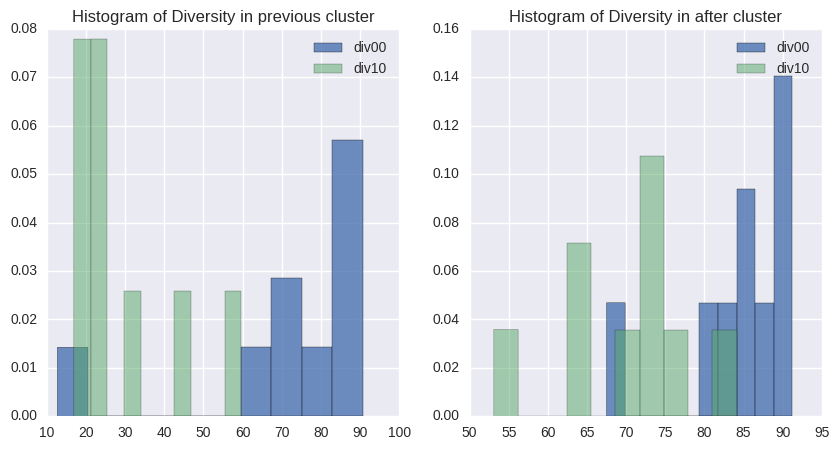

In [2538]:
check_label(ziptest, 3, 2)

#### The feature weighed most in change from cluster 3 and cluster 2 is "diversity".

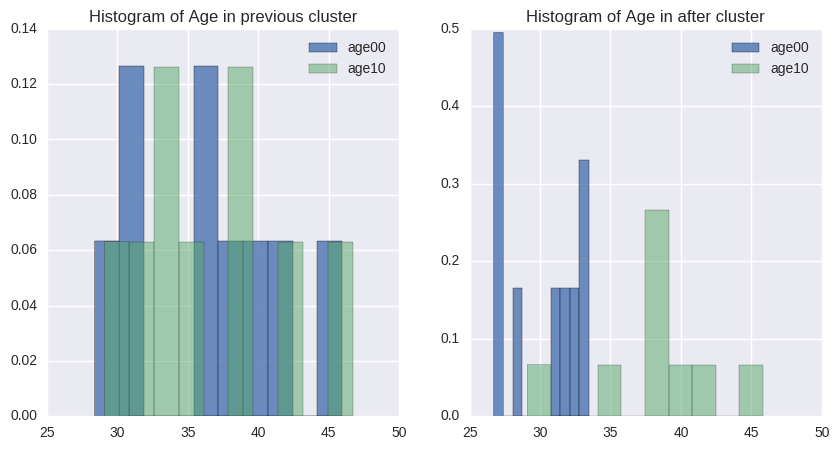

In [2540]:
check_label(ziptest2, 2, 1)

#### The feature weighed most in change from cluster 1 and cluster 2 is "age".

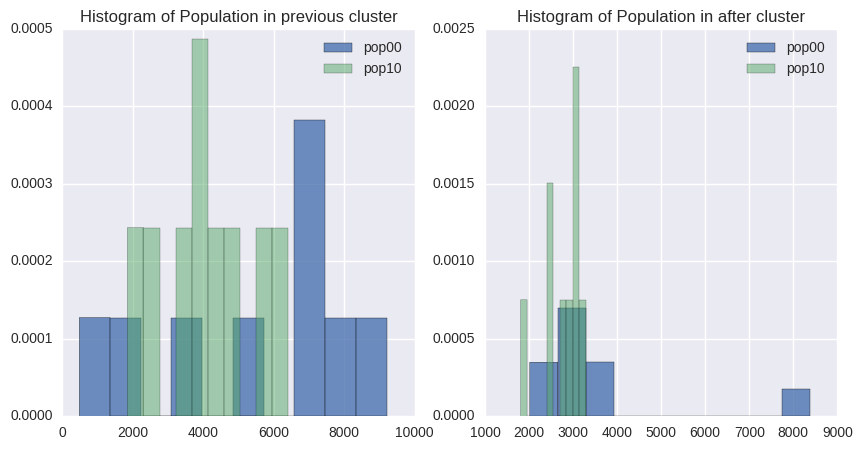

In [2519]:
check_label(ziptest1, 2, 0)

#### The feature weighed most in change from cluster 0 and cluster 2 is "population".

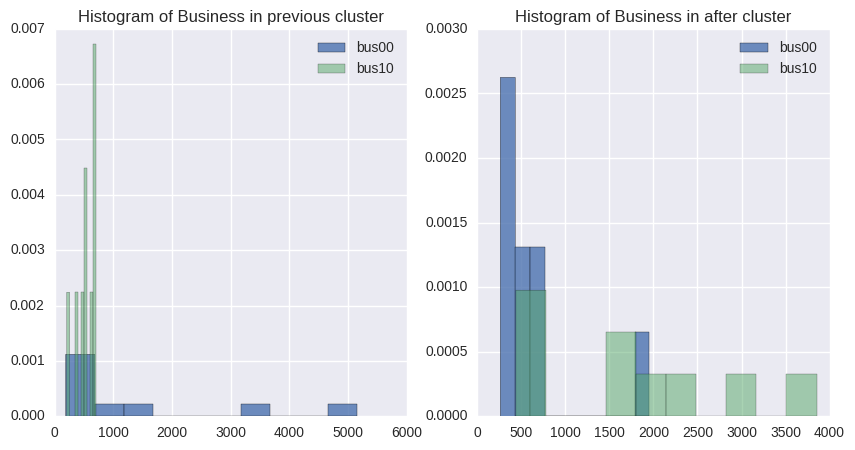

In [2546]:
check_label(ziptest3, 3, 1)

#### The feature weighed most in change from cluster 3 and cluster 1 is "business".

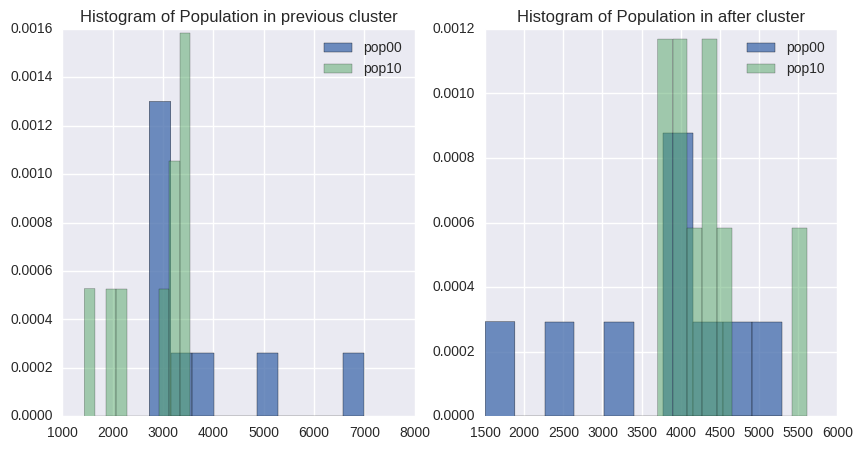

In [2551]:
check_label(ziptest4, 0, 3)

In [2552]:
#### The feature weighed most in change from cluster 3 and cluster 0 is "population".

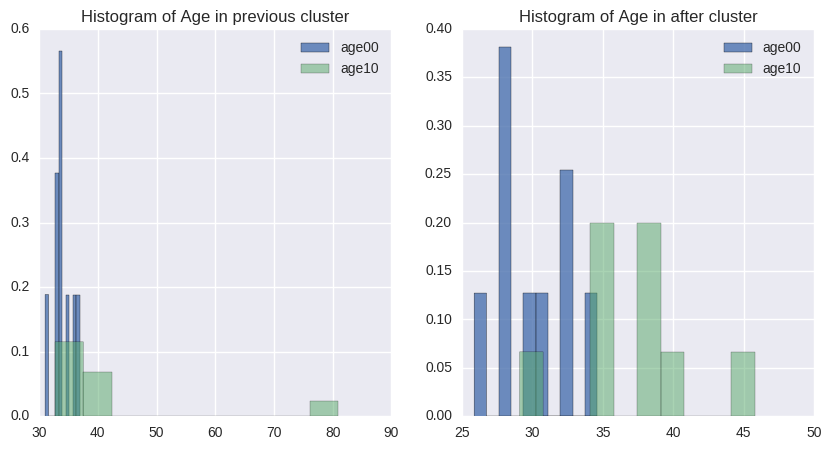

In [2548]:
check_label(ziptest5, 0, 1)

#### The feature weighed most in change from cluster 0 and cluster 1 is "age".

## (13) Summary
### In this analysis we used census tract dataset which include the information of age, diversity, population, income and business activity stored reginally, which means that these dataset give us information of this features from different location. The location was divided into different census tract, each census tract contain several geometry point. In this research we transfer the numerical information to visible geometrical pattern. So that we can see the features patter more clearly on map,thus we can conclude geometrical characters of different features and find some correlation in location of different features. Sunch as the income and business features share similar geometrical patter. That is in location where more business activity happened people there also intend to earn more. Also in these places diversity is  also higher.
### But this analysis approach also has some weakness, since we use the mean, for some features it doesn't show clear pattern. Also I think its better to cluster zipcode than census. When we compare the pearson correlation of different year in different cluster, since the size of cluster is different, thus I narrowed the size to the smallest cluster, which I think in this step many information may lost. But I cannot figure out the right way to do this.
